#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA-II/NSGA-III/MOEA/D; except for NSGA).
- Note that it has to be your implementation (using external libraries is forbidden; EXCEPTION: you can use the JECDM framework: https://jecdm.cs.put.poznan.pl -- but it is a relatively complex software, and much effort must be spent to understand how to use it).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, tackle also a three-objective one. As for the third objective, think about some reasonable risk-measure. E.g., you can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

# Portfolio optimization

Import the necessary libraries (numpy, pandas, matplotlib, cvxopt).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

# For reproducible randomness
np.random.seed(42)

Load the data from *Part1.txt files. Each file’s first line is the asset name, second line is N, and then N lines with “time price”.

In [2]:
def load_asset_data(data_folder="data"):
    asset_names = []
    asset_times = []
    asset_prices = []
    
    txt_files = [f for f in os.listdir(data_folder) if f.endswith("Part3.txt")]
    
    for fname in txt_files:
        path = os.path.join(data_folder, fname)
        with open(path, "r") as f:
            # 1) asset name
            asset_name = f.readline().strip()
    
            # 2) number of data points
            N_line = f.readline().strip()
            N = int(N_line)
    
            # 3) read time, price lines
            times = []
            prices = []
            for _ in range(N):
                line = f.readline().strip()
                t_str, p_str = line.split()
                times.append(float(t_str))
                prices.append(float(p_str))
    
            asset_names.append(asset_name)
            asset_times.append(times)
            asset_prices.append(prices)
    
    print(f"Found {len(asset_names)} assets.")
    print("First few asset names:", asset_names[:5])
    return asset_names, asset_times, asset_prices

asset_names, asset_times, asset_prices = load_asset_data()

Found 20 assets.
First few asset names: ['SafeAndCare', 'Fuel4', 'Moneymakers', 'MarsProject', 'CPU-XYZ']


In [3]:
def plot_asset_forecasts(asset_names, asset_times, asset_prices, forecast_results, training_offset=100, color="red"):
    """
    Plots forecast data for multiple assets on a 5x4 grid.
    
    Parameters:
      asset_names (list): List of asset names.
      asset_times (list of arrays/lists): Time points for each asset.
      asset_prices (list of arrays/lists): Historical prices for each asset.
      forecast_results (dict): Dictionary mapping asset names to forecast results for a specific method.
          Each entry for an asset should contain:
            - "price_at_training": forecast price at training time.
            - "price_at_forecast": forecast price at forecast time.
            - "full_reconstruction": (optional) tuple (recon_times, reconstruction) for the full reconstruction curve.
            - "forecast_time": (optional) forecast time (defaults to 200 if not provided).
      training_offset (int): The offset between forecast time and training time (default 100).
      color (str): Color for all forecast markers and lines.
    
    The function creates a grid of subplots (max 20 assets), where for each asset:
      - Historical data is plotted as black scatter points.
      - A training marker is plotted at (forecast_time - training_offset) using a circle marker.
      - A forecast marker is plotted at forecast_time using an 'x' marker.
      - If available, a reconstruction curve is plotted.
    """
    
    # Set up a 5x4 grid (max 20 assets)
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    axes = axes.flatten()
    
    num_assets = min(len(asset_names), 20)
    
    for i in range(num_assets):
        ax = axes[i]
        asset = asset_names[i]
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Plot historical data
        ax.scatter(times, prices, label="Historical Prices", color="black")
        
        # Retrieve forecast result for this asset
        forecast = forecast_results[asset]
        forecast_time = forecast.get("forecast_time", 200)
        training_time = forecast_time - training_offset
        
        # Plot training marker
        ax.scatter([training_time], [forecast["price_at_training"]],
                   marker="o", color=color, s=100,
                   label=f"Training @ t={training_time}")
        
        # Plot forecast marker
        ax.scatter([forecast_time], [forecast["price_at_forecast"]],
                   marker="x", color=color, s=100,
                   label=f"Forecast @ t={forecast_time}")
        
        # Plot reconstruction curve if available
        if "full_reconstruction" in forecast:
            recon_times, reconstruction = forecast["full_reconstruction"]
            ax.plot(recon_times, reconstruction, label="Reconstruction",
                    color=color, linewidth=2)
        
        ax.set_title(asset)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend(fontsize='small')
    
    # Remove any unused subplots if there are fewer than 20 assets.
    for j in range(num_assets, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [4]:
all_results = {}

Perform a simple linear regression (degree=1) for each asset using times in [0,100]. Extrapolate to time=200 to get a predicted price. Convert that predicted price growth into a predicted return \mu[i].

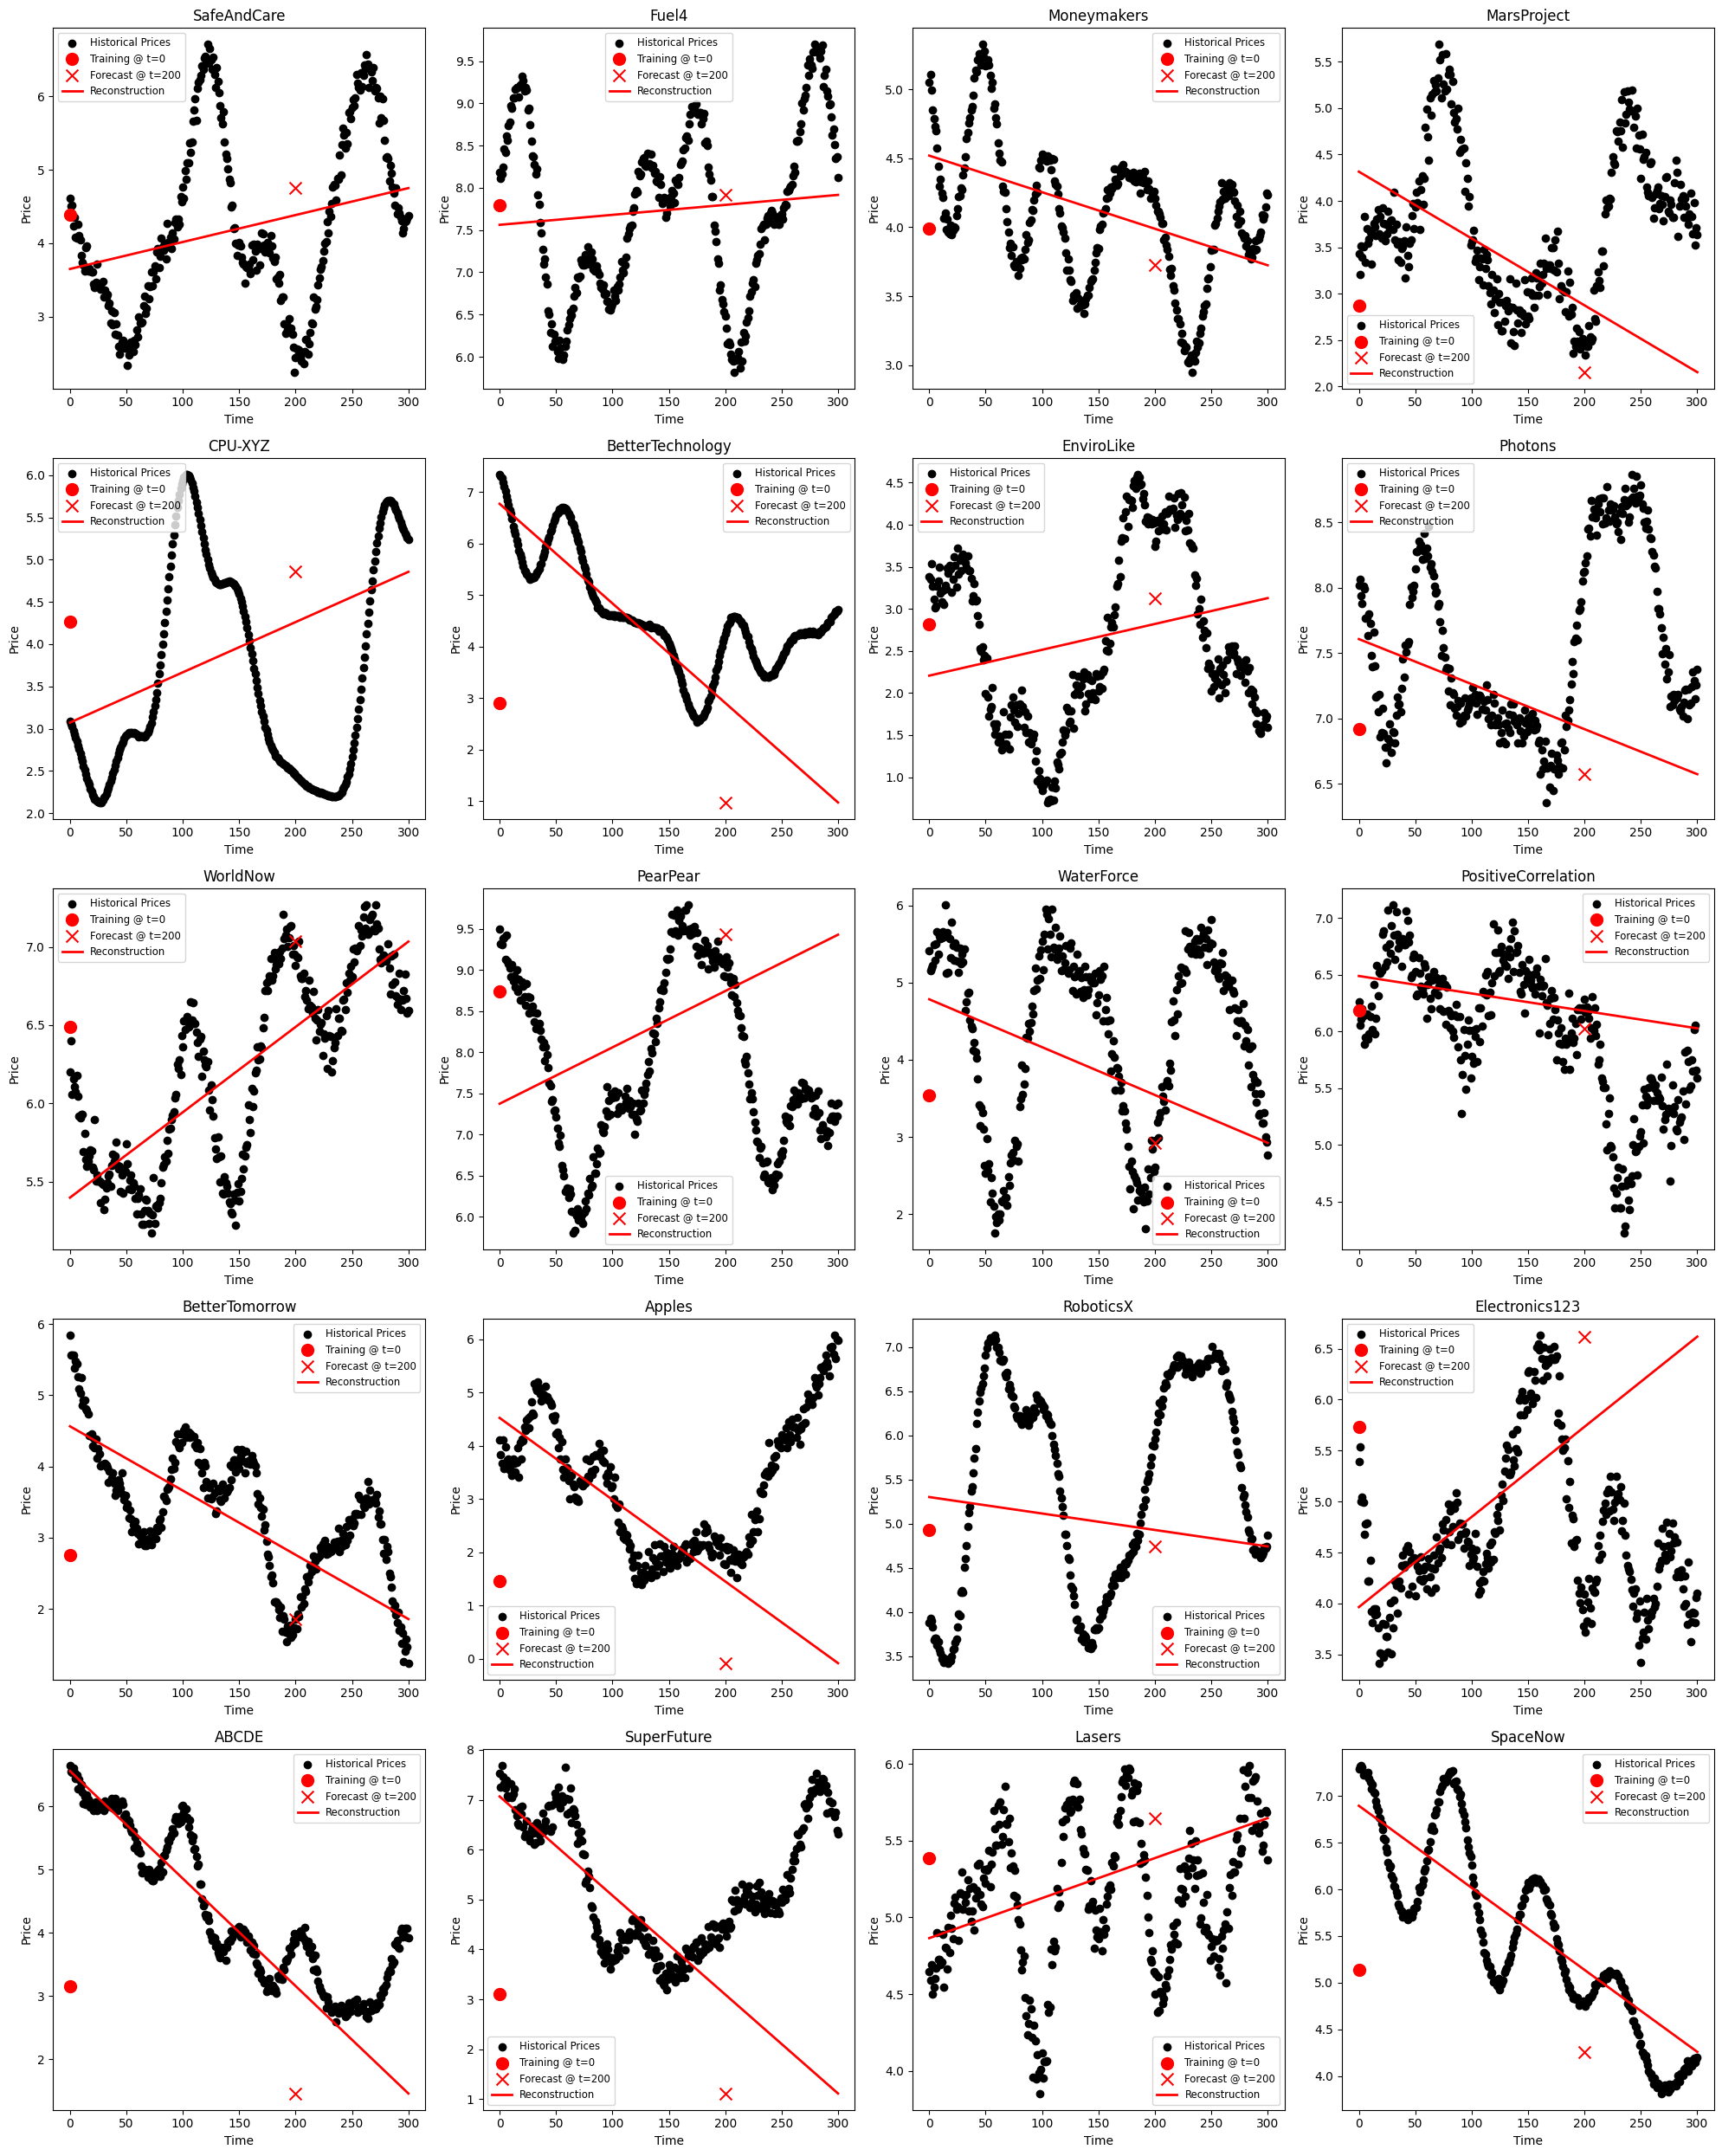

In [5]:
import numpy as np
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

def baseline_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200):
    """
    
    Returns a dictionary with, for each asset:
      - "model_predictions": (training_times, model_predictions) on [training_start, training_end]
      - "full_reconstruction": (recon_times, linear_reconstruction) on [training_start, forecast_time]
      - "price_at_training": predicted price at training_end
      - "price_at_forecast": predicted price at forecast_time
      - "predicted_return": computed return
    """
    baseline_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        # Use training data: times between training_start and training_end
        mask = (times >= training_start) & (times <= training_end)
        t_used = times[mask]
        p_used = prices[mask]
        coeffs = np.polyfit(t_used, p_used, deg=1)
        # Model predictions on training interval
        model_predictions = np.polyval(coeffs, t_used)
        price_at_training = np.polyval(coeffs, training_end)
        price_at_forecast = np.polyval(coeffs, forecast_time)
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        # Generate a new time vector for full reconstruction:
        recon_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
        linear_reconstruction = np.polyval(coeffs, recon_times)
        
        baseline_pred[name] = {
            "model_predictions": (t_used, model_predictions),
            "full_reconstruction": (recon_times, linear_reconstruction),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return baseline_pred
    
linear_results = baseline_forecast(asset_names, asset_times, asset_prices,
                                          training_start=0, training_end=200, forecast_time=300)
plot_asset_forecasts(asset_names, asset_times, asset_prices, linear_results, training_offset=200, color="red")


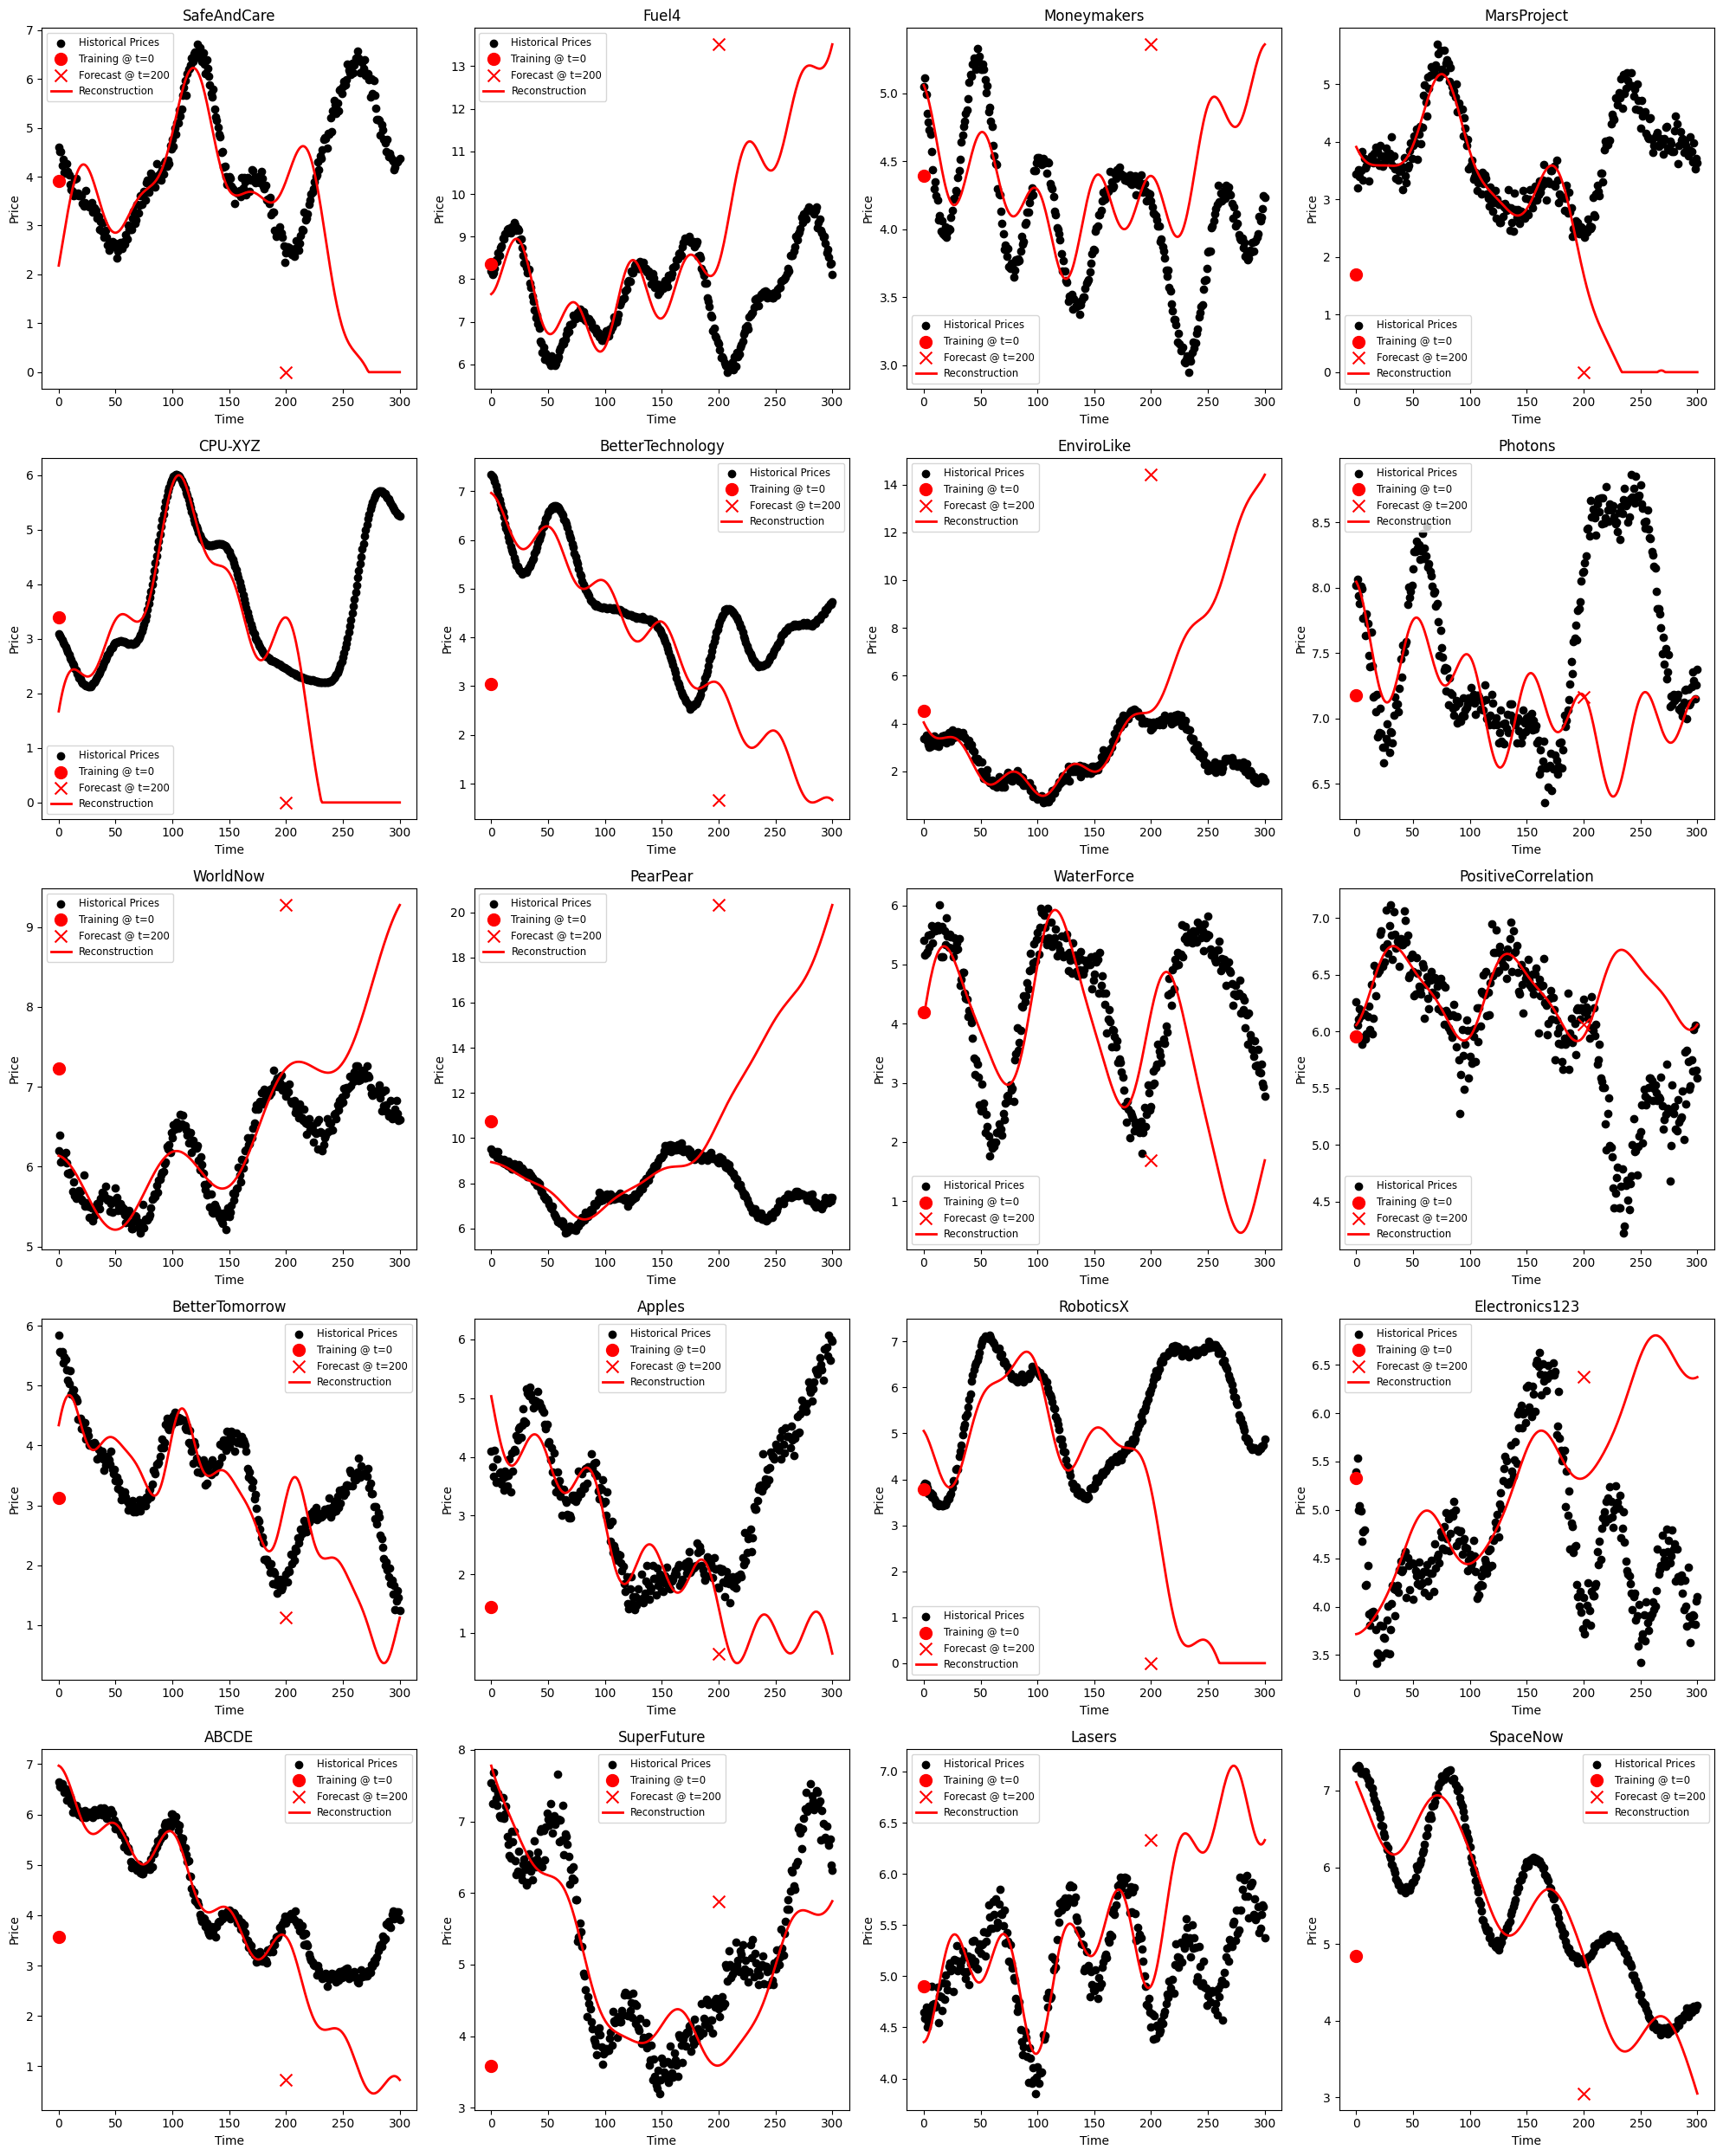

In [6]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import Lasso

def build_candidate_library(x, candidate_frequencies):
    """
    Build a design matrix with a constant, linear, quadratic term,
    and for each candidate frequency, sine and cosine functions.
    """
    features = []
    feature_names = []
    features.append(np.ones_like(x))
    feature_names.append('1')
    features.append(x)
    feature_names.append('x')
    features.append(x**2)
    feature_names.append('x^2')
    for w in candidate_frequencies:
        features.append(np.sin(2 * np.pi * w * x))
        feature_names.append(f'sin(2π*{w:.2f}x)')
        features.append(np.cos(2 * np.pi * w * x))
        feature_names.append(f'cos(2π*{w:.2f}x)')
    X = np.column_stack(features)
    return X, feature_names

def sparse_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200, alpha=0.01):
    """
    For each asset, perform:
      1. Denoise the full signal.
      2. From training data ([training_start, training_end]), perform FFT on the denoised data
         to select candidate frequencies.
      3. Compute the linear trend using raw training data.
      4. Subtract the trend from the denoised training data.
      5. Build a candidate library over the full time series.
      6. Fit a sparse (LASSO) model on the detrended training data.
      7. Reconstruct the full signal (by adding back the extrapolated trend).
      8. Evaluate the learned function at any new x using the candidate library.
    """
    sparse_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # 1. Denoise the full signal.
        prices_denoised = savgol_filter(prices, window_length=11, polyorder=2)
        
        # 2. Restrict to training data and perform FFT on the denoised training data.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train_denoised = prices_denoised[mask]
        N = len(t_train)
        T = t_train[1] - t_train[0] if N > 1 else 1
        fft_vals = np.fft.fft(p_train_denoised)
        freq = np.fft.fftfreq(N, T)
        pos_mask = freq > 0
        freq_pos = freq[pos_mask]
        fft_magnitude = np.abs(fft_vals)[pos_mask]
        threshold = np.mean(fft_magnitude) + 1 * np.std(fft_magnitude)
        candidate_frequencies = freq_pos[fft_magnitude > threshold]
        candidate_frequencies = np.unique(np.round(candidate_frequencies, 2))
        
        # 3. Compute trend using raw training data (to preserve the true slope).
        p_train_raw = prices[mask]
        coeffs_trend = np.polyfit(t_train, p_train_raw, 1)
        trend_train = np.polyval(coeffs_trend, t_train)
        
        # 4. Subtract the trend from the denoised training data.
        p_train_detrended = p_train_denoised - trend_train
        
        # 5. Build candidate library over the full time series.
        X, _ = build_candidate_library(times, candidate_frequencies)
        X_train = X[mask, :]
        
        # 6. Fit sparse regression (LASSO) on detrended training data.
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_train, p_train_detrended)
        coefs = lasso.coef_
        intercept_sparse = lasso.intercept_
        
        # 7. Reconstruct the full signal.
        p_detrended_reconstructed = intercept_sparse + X.dot(coefs)
        trend_full = np.polyval(coeffs_trend, times)
        p_reconstructed = p_detrended_reconstructed + trend_full
        # Clip negative values in the training reconstruction:
        p_reconstructed = np.maximum(p_reconstructed, 0)
        
        # 8. Define a prediction function that evaluates the learned function at any new x.
        def predict_new(x_new):
            X_new, _ = build_candidate_library(np.array([x_new]), candidate_frequencies)
            value = intercept_sparse + X_new.dot(coefs) + np.polyval(coeffs_trend, x_new)
            # Return non-negative prediction.
            return max(value.item(), 0)
        
        price_at_training = predict_new(training_end)
        price_at_forecast = predict_new(forecast_time)
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        # Generate a new reconstruction time vector from training_start to forecast_time.
        recon_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
        X_new, _ = build_candidate_library(recon_times, candidate_frequencies)
        p_detrended_new = intercept_sparse + X_new.dot(coefs)
        p_reconstructed_new = p_detrended_new + np.polyval(coeffs_trend, recon_times)
        # Clip negative values.
        p_reconstructed_new = np.maximum(p_reconstructed_new, 0)
        
        sparse_pred[name] = {
            "model_predictions": (t_train, np.maximum(p_reconstructed[mask], 0)),  # for diagnostic on training data
            "full_reconstruction": (recon_times, p_reconstructed_new),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return sparse_pred

# Example usage:
sparse_results = sparse_forecast(asset_names, asset_times, asset_prices,
                                 training_start=0, training_end=200, forecast_time=300)
plot_asset_forecasts(asset_names, asset_times, asset_prices, sparse_results, training_offset=200, color="red")


Illustrate your predictions by plotting the historical data and the linear fit for a few assets, plus the forecasted price at t=200.

/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

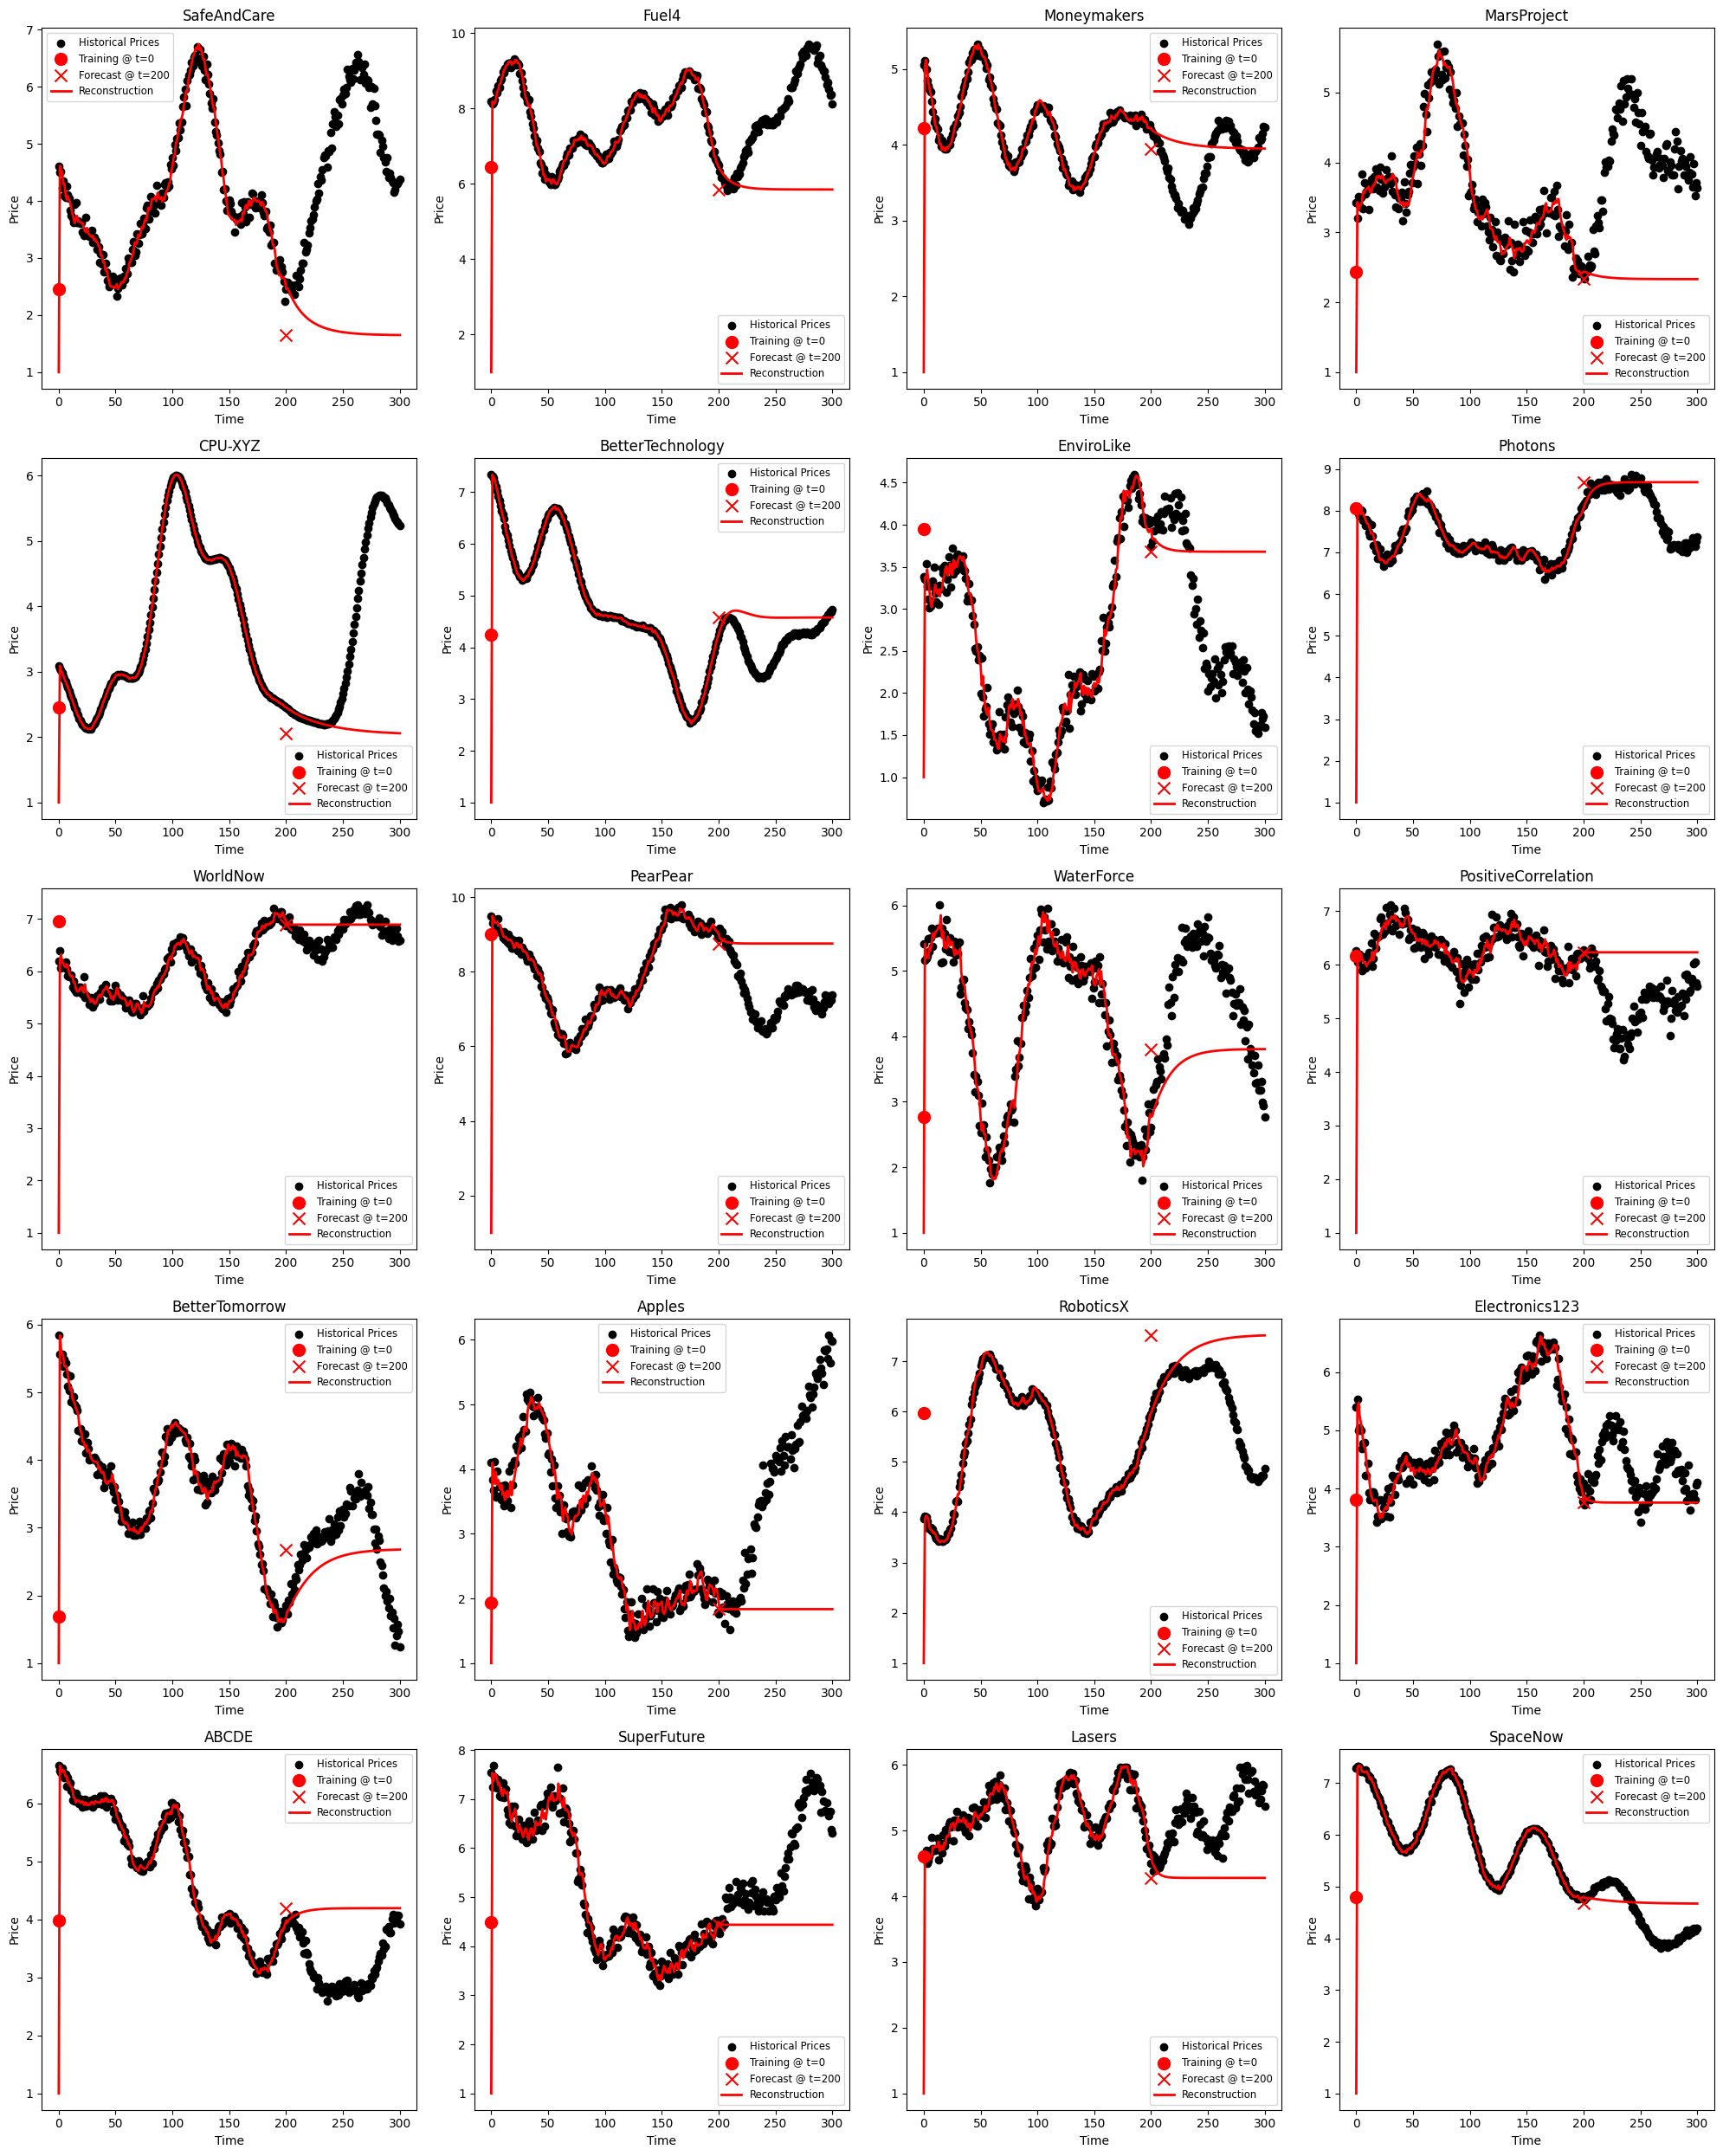

In [7]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200, order=(1,1,1), use_log=True):
    """
    For each asset, fit an ARIMA model on training data ([training_start, training_end])
    and forecast up to forecast_time.
    
    If use_log is True, a logarithmic transformation is applied to the training data,
    and forecasts are exponentiated to ensure all predictions are positive.
    
    Computes expected return as:
      (price_at_forecast - price_at_training) / price_at_training.
    
    Returns a dictionary with, for each asset:
      - "model_predictions": (training_times, in-sample predictions) on [training_start, training_end]
      - "full_reconstruction": (recon_times, arima_predictions) on [training_start, forecast_time]
      - "price_at_training": predicted price at training_end (last training prediction)
      - "price_at_forecast": predicted price at forecast_time (last forecast value)
      - "predicted_return": computed return
    """
    arima_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data based on the provided time window.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        if use_log:
            # Check that all training prices are positive.
            if np.any(p_train <= 0):
                raise ValueError(f"Asset {name} has non-positive prices; cannot use log transform.")
            p_train_trans = np.log(p_train)
        else:
            p_train_trans = p_train.copy()
        
        # Fit the ARIMA model on the (possibly transformed) training data.
        try:
            model = ARIMA(p_train_trans, order=order)
            model_fit = model.fit()
        except Exception as e:
            print(f"ARIMA fit failed for asset {name}: {e}")
            continue
        
        # In-sample prediction on the training data.
        pred_train_trans = model_fit.predict(start=0, end=len(p_train_trans)-1)
        # If using log transform, exponentiate predictions.
        if use_log:
            pred_train = np.exp(pred_train_trans)
        else:
            pred_train = pred_train_trans
        
        # Determine forecast steps.
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Forecast future values.
        forecast_trans = model_fit.forecast(steps=forecast_steps)
        if use_log:
            forecast = np.exp(forecast_trans)
        else:
            forecast = forecast_trans
        
        # Construct full time series reconstruction.
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([pred_train, forecast])
        
        # Get the predicted price at training_end and forecast_time.
        price_at_training = pred_train[-1]
        price_at_forecast = forecast[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        # In case any residual negatives appear (shouldn't happen with log-transform):
        full_predictions = np.maximum(full_predictions, 0)
        
        arima_pred[name] = {
            "model_predictions": (t_train, pred_train),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return arima_pred

# Example usage:
# (Ensure asset_names, asset_times, asset_prices, and plot_asset_forecasts are defined.)
arima_results = arima_forecast(asset_names, asset_times, asset_prices,
                               training_start=0, training_end=200, forecast_time=300,
                               order=(2,1,2), use_log=True)
plot_asset_forecasts(asset_names, asset_times, asset_prices, arima_results, training_offset=200, color="red")


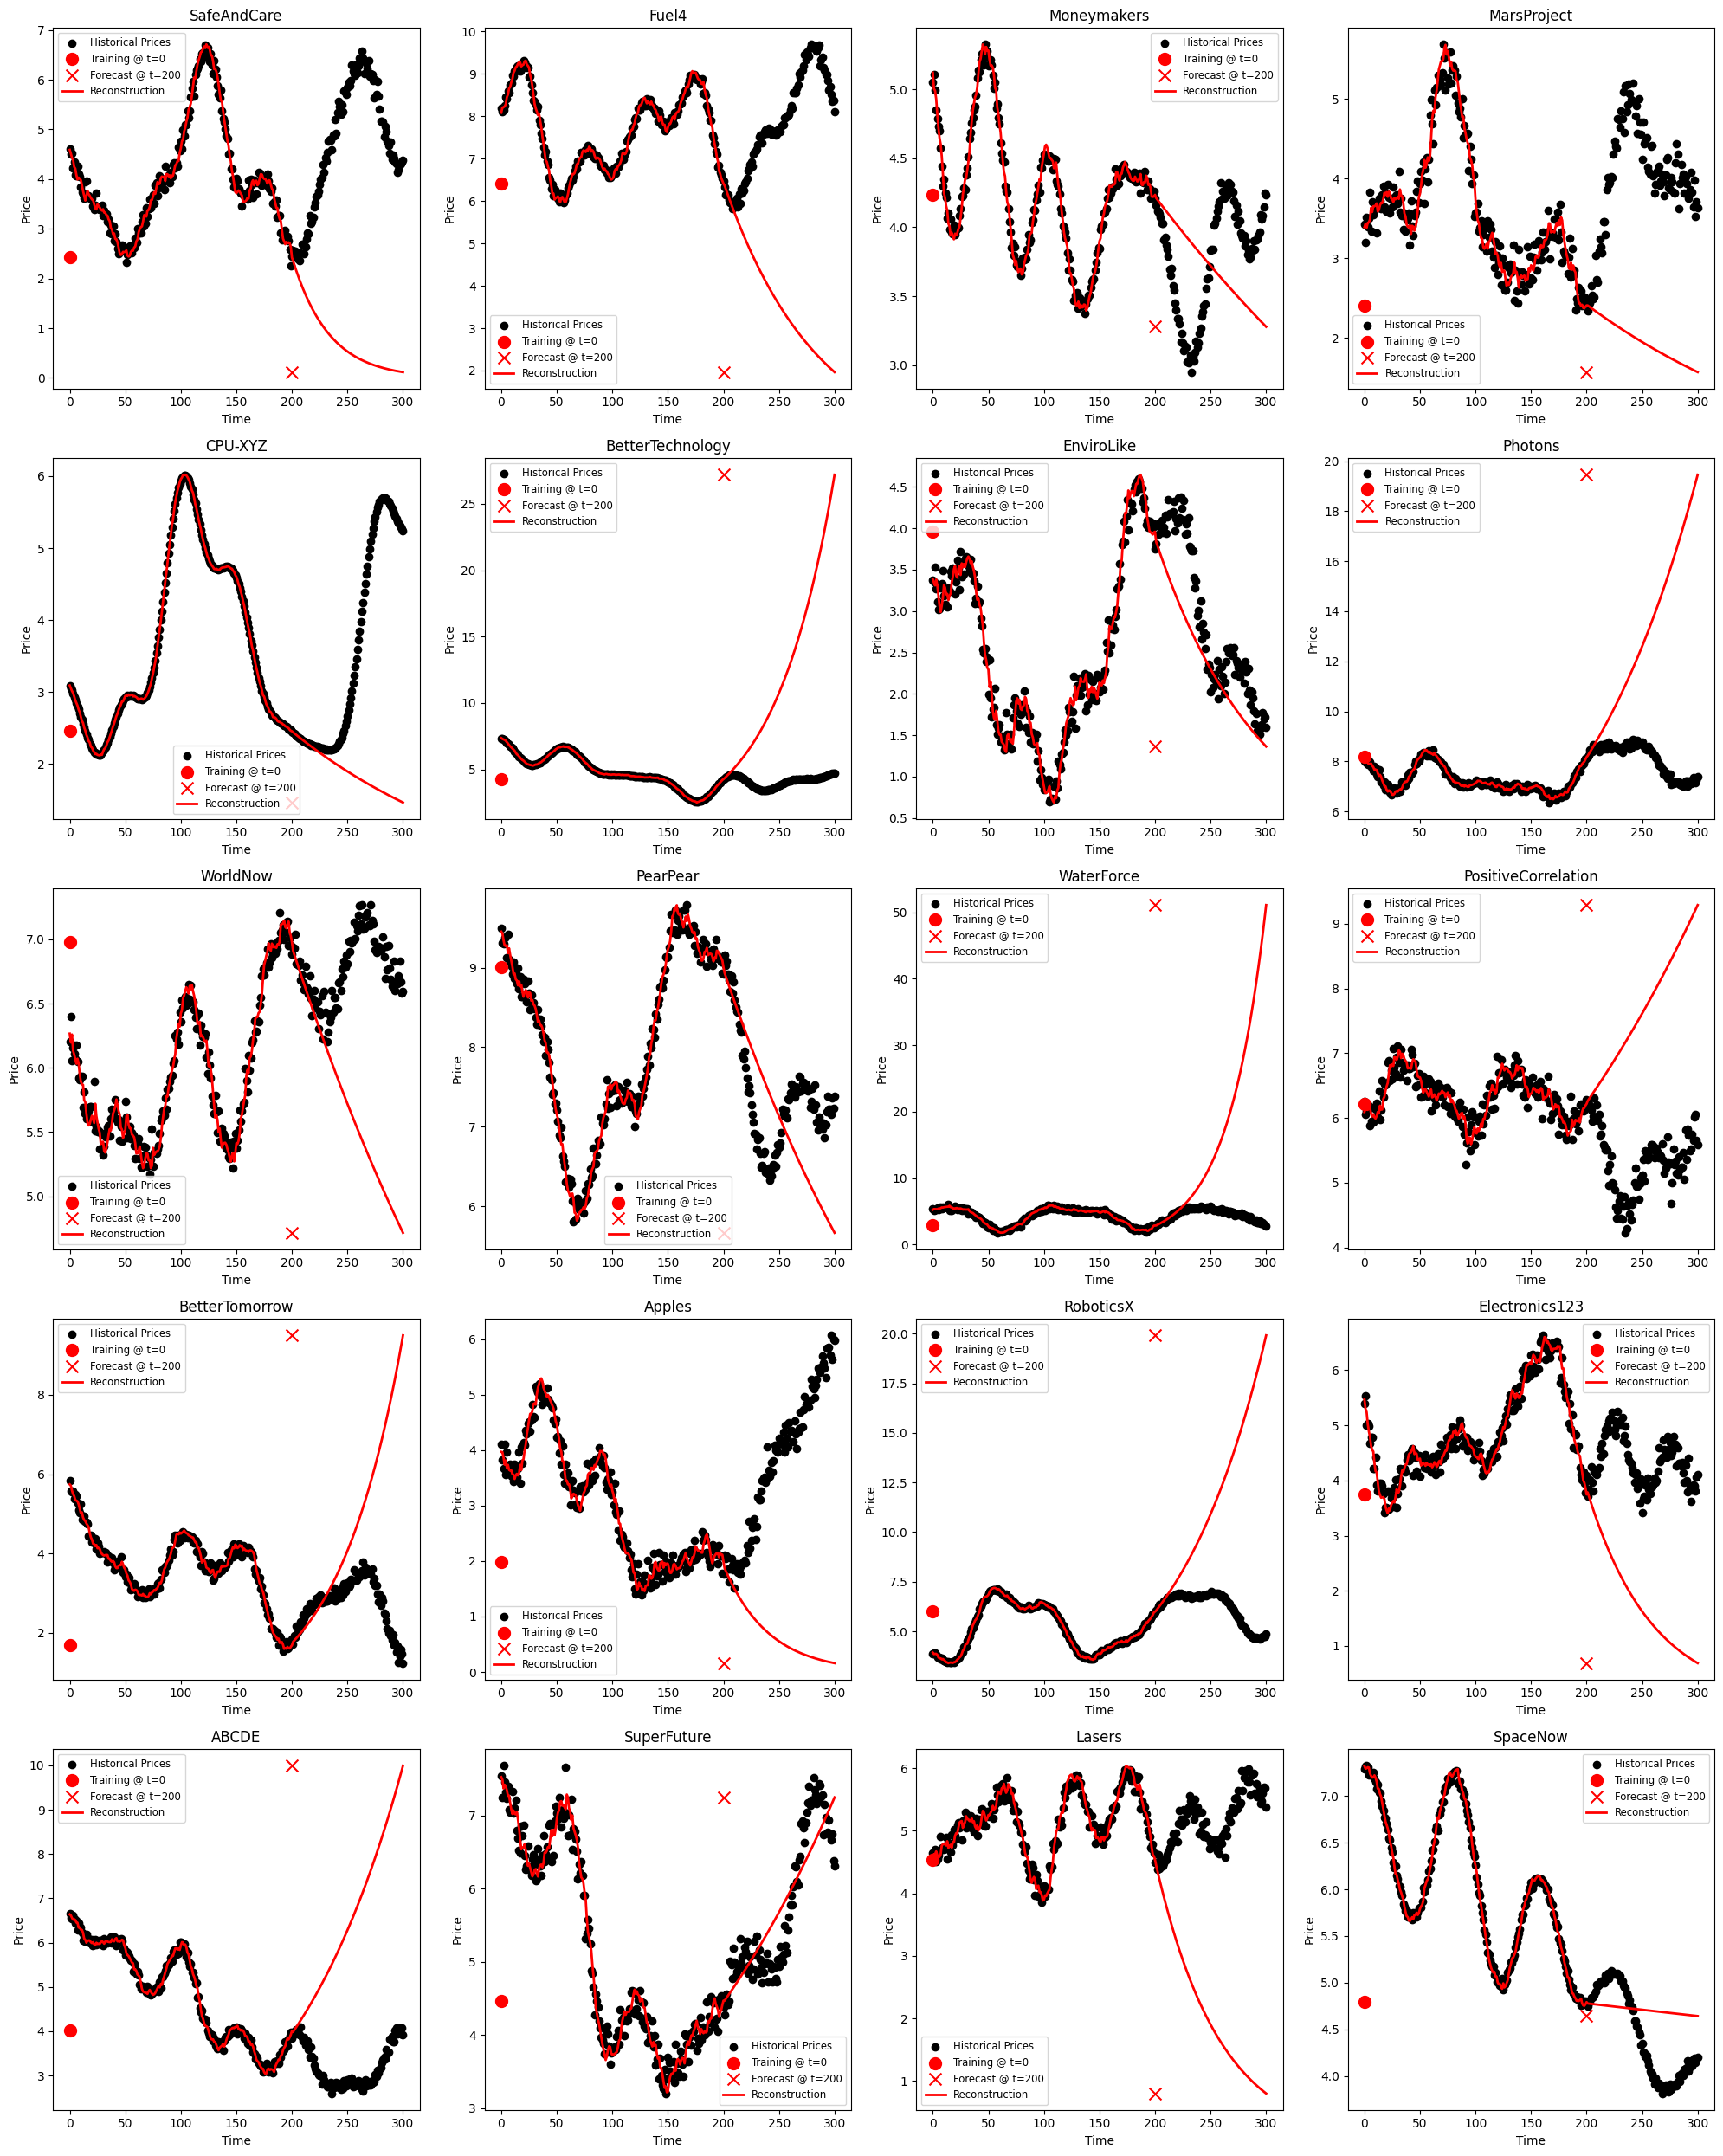

In [8]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exponential_smoothing_forecast(asset_names, asset_times, asset_prices,
                                   training_start=0, training_end=100, forecast_time=200,
                                   trend='add', seasonal=None, seasonal_periods=None,
                                   use_multiplicative=False):
    """
    Returns:
      A dictionary where each key is an asset name and each value is a dictionary containing:
        - "model_predictions": (training_times, in-sample predictions) on [training_start, training_end]
        - "full_reconstruction": (recon_times, exponential smoothing predictions) on [training_start, forecast_time]
        - "price_at_training": predicted price at training_end (last in-sample prediction)
        - "price_at_forecast": predicted price at forecast_time (last forecast value)
        - "predicted_return": computed return as (price_at_forecast - price_at_training) / price_at_training
    """
    exp_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data based on the provided time window.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        # Optionally, use multiplicative components if data are strictly positive.
        if use_multiplicative:
            if np.any(p_train <= 0):
                print(f"Warning: Asset {name} has non-positive values. Multiplicative model not appropriate. Using additive model.")
            else:
                trend = 'mul'
                if seasonal is not None:
                    seasonal = 'mul'
        
        # Fit the exponential smoothing model.
        try:
            model = ExponentialSmoothing(p_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            model_fit = model.fit()
        except Exception as e:
            print(f"Exponential Smoothing model fit failed for asset {name}: {e}")
            continue
        
        # In-sample fitted values (for training period).
        pred_train = model_fit.fittedvalues
        # Clip negative values.
        pred_train = np.maximum(pred_train, 0)
        
        # Determine number of forecast steps.
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Forecast future values.
        forecast_values = model_fit.forecast(steps=forecast_steps)
        forecast_values = np.maximum(forecast_values, 0)
        
        # Generate a time vector for the forecast period.
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        # Build the full reconstruction time series.
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([pred_train, forecast_values])
        full_predictions = np.maximum(full_predictions, 0)  # ensure non-negative
        
        # Get the predicted prices at training_end and forecast_time.
        price_at_training = pred_train[-1]
        price_at_forecast = forecast_values[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        exp_pred[name] = {
            "model_predictions": (t_train, pred_train),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return exp_pred

exp_results = exponential_smoothing_forecast(asset_names, asset_times, asset_prices,
                                             training_start=0, training_end=200, forecast_time=300,
                                             trend='add', seasonal=None, seasonal_periods=None,
                                             use_multiplicative=True)
plot_asset_forecasts(asset_names, asset_times, asset_prices, exp_results, training_offset=200, color="red")


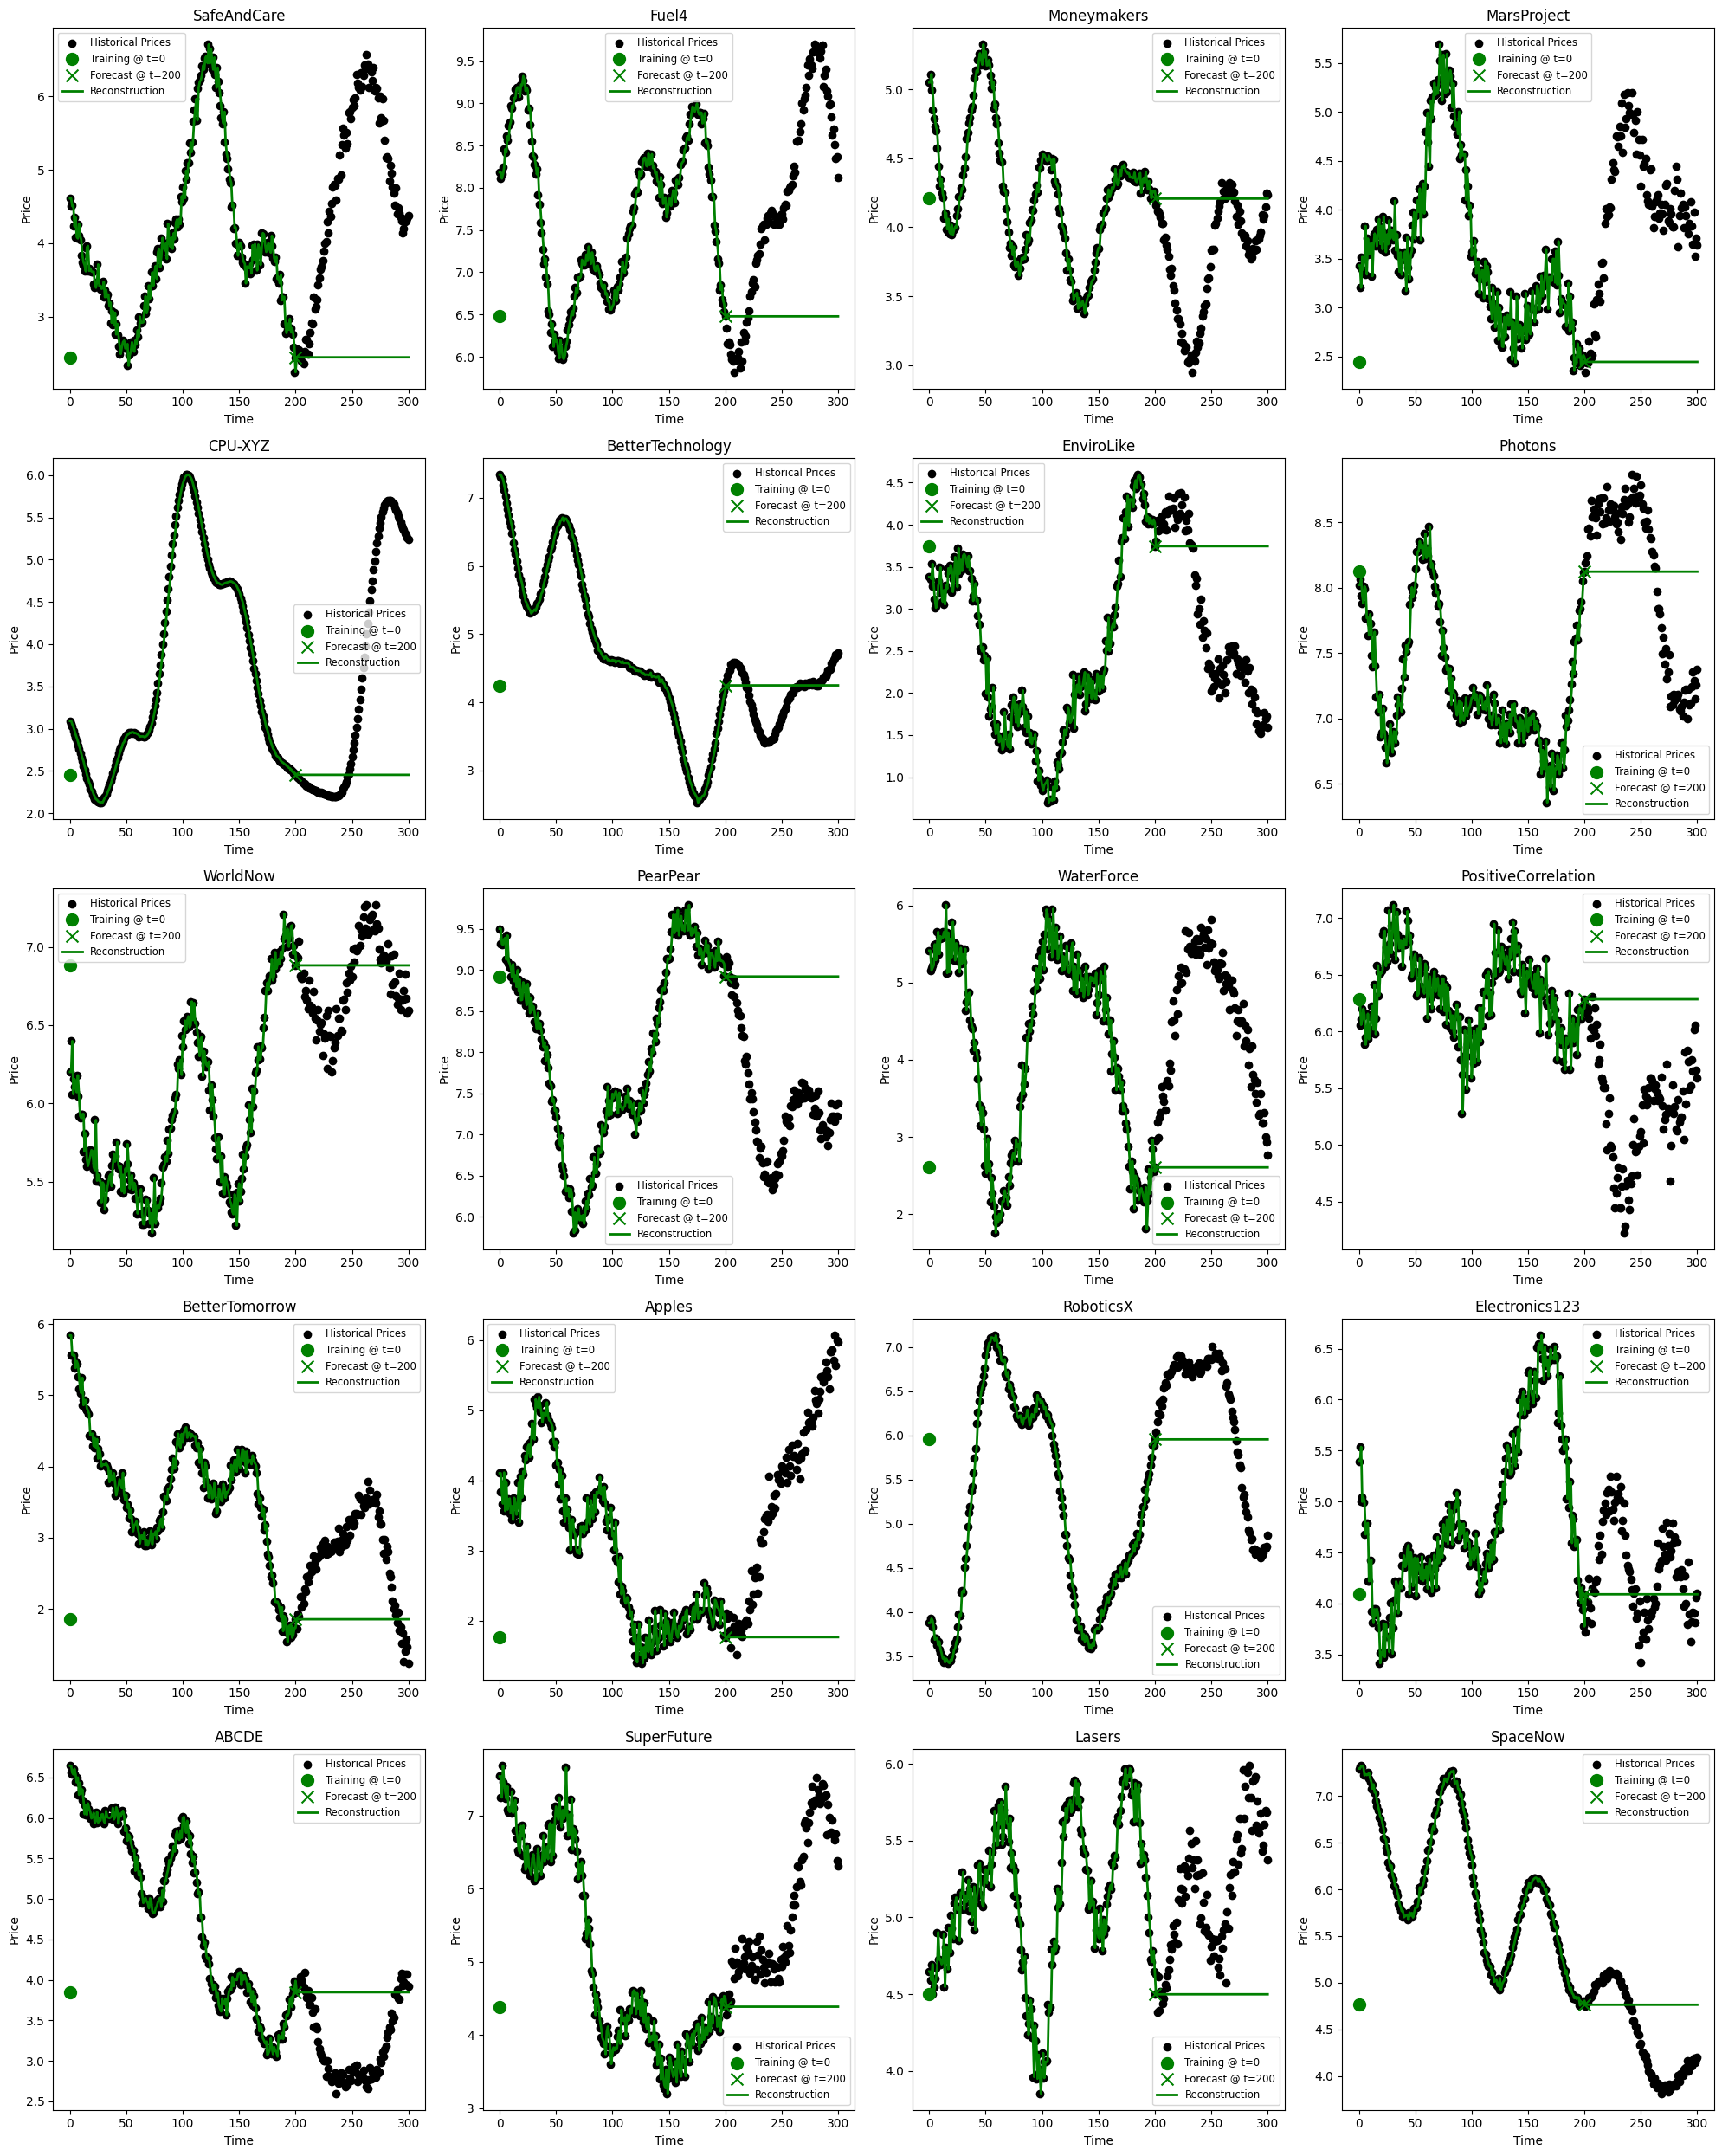

In [9]:
import numpy as np
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster

def naive_forecast(asset_names, asset_times, asset_prices,
                   training_start=0, training_end=100, forecast_time=200, strategy="last"):
    """
    Returns:
      A dictionary where for each asset the following keys are returned:
        - "model_predictions": (training_times, in-sample naive predictions) on [training_start, training_end]
        - "full_reconstruction": (recon_times, naive forecast predictions) on [training_start, forecast_time]
        - "price_at_training": reference price at training_end (from actual training data)
        - "price_at_forecast": forecasted price at forecast_time
        - "predicted_return": computed return as (price_at_forecast - price_at_training) / price_at_training
    """
    naive_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data: times between training_start and training_end.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        # Compute in-sample naive predictions.
        if strategy == "last":
            in_sample_predictions = np.empty_like(p_train)
            in_sample_predictions[0] = p_train[0]
            if len(p_train) > 1:
                in_sample_predictions[1:] = p_train[:-1]
        elif strategy == "drift":
            if len(p_train) > 1:
                drift = (p_train[-1] - p_train[0]) / (len(p_train) - 1)
            else:
                drift = 0
            in_sample_predictions = np.empty_like(p_train)
            in_sample_predictions[0] = p_train[0]
            for j in range(1, len(p_train)):
                in_sample_predictions[j] = p_train[j-1] + drift
        elif strategy == "mean":
            mean_value = np.mean(p_train)
            in_sample_predictions = np.full_like(p_train, fill_value=mean_value)
        else:
            raise ValueError("Unsupported strategy. Use 'last', 'drift', or 'mean'.")
        
        # Clip negative in-sample predictions.
        in_sample_predictions = np.maximum(in_sample_predictions, 0)
        
        # Determine the number of forecast steps.
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Prepare the training series for sktime.
        # Assuming training times are consecutive integers.
        y_train = pd.Series(p_train, index=pd.RangeIndex(start=int(t_train[0]),
                                                         stop=int(t_train[0]) + len(t_train)))
        
        # Fit the NaiveForecaster from sktime.
        forecaster = NaiveForecaster(strategy=strategy)
        forecaster.fit(y_train)
        fh = np.arange(1, forecast_steps + 1)  # forecasting horizon (steps ahead)
        y_forecast = forecaster.predict(fh)
        
        # Clip forecast predictions to ensure non-negativity.
        forecast_values = np.maximum(y_forecast.values, 0)
        
        # Create forecast time points (assuming integer time steps).
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        
        # Full reconstruction: combine in-sample predictions and forecast values.
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([in_sample_predictions, forecast_values])
        
        # Determine prices at training_end and forecast_time.
        price_at_training = p_train[-1]  # using actual last training price as reference
        price_at_forecast = forecast_values[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        naive_pred[name] = {
            "model_predictions": (t_train, in_sample_predictions),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return naive_pred

# Example usage:
naive_results = naive_forecast(asset_names, asset_times, asset_prices,
                               training_start=0, training_end=200, forecast_time=300, strategy="last")
plot_asset_forecasts(asset_names, asset_times, asset_prices, naive_results, training_offset=200, color="green")


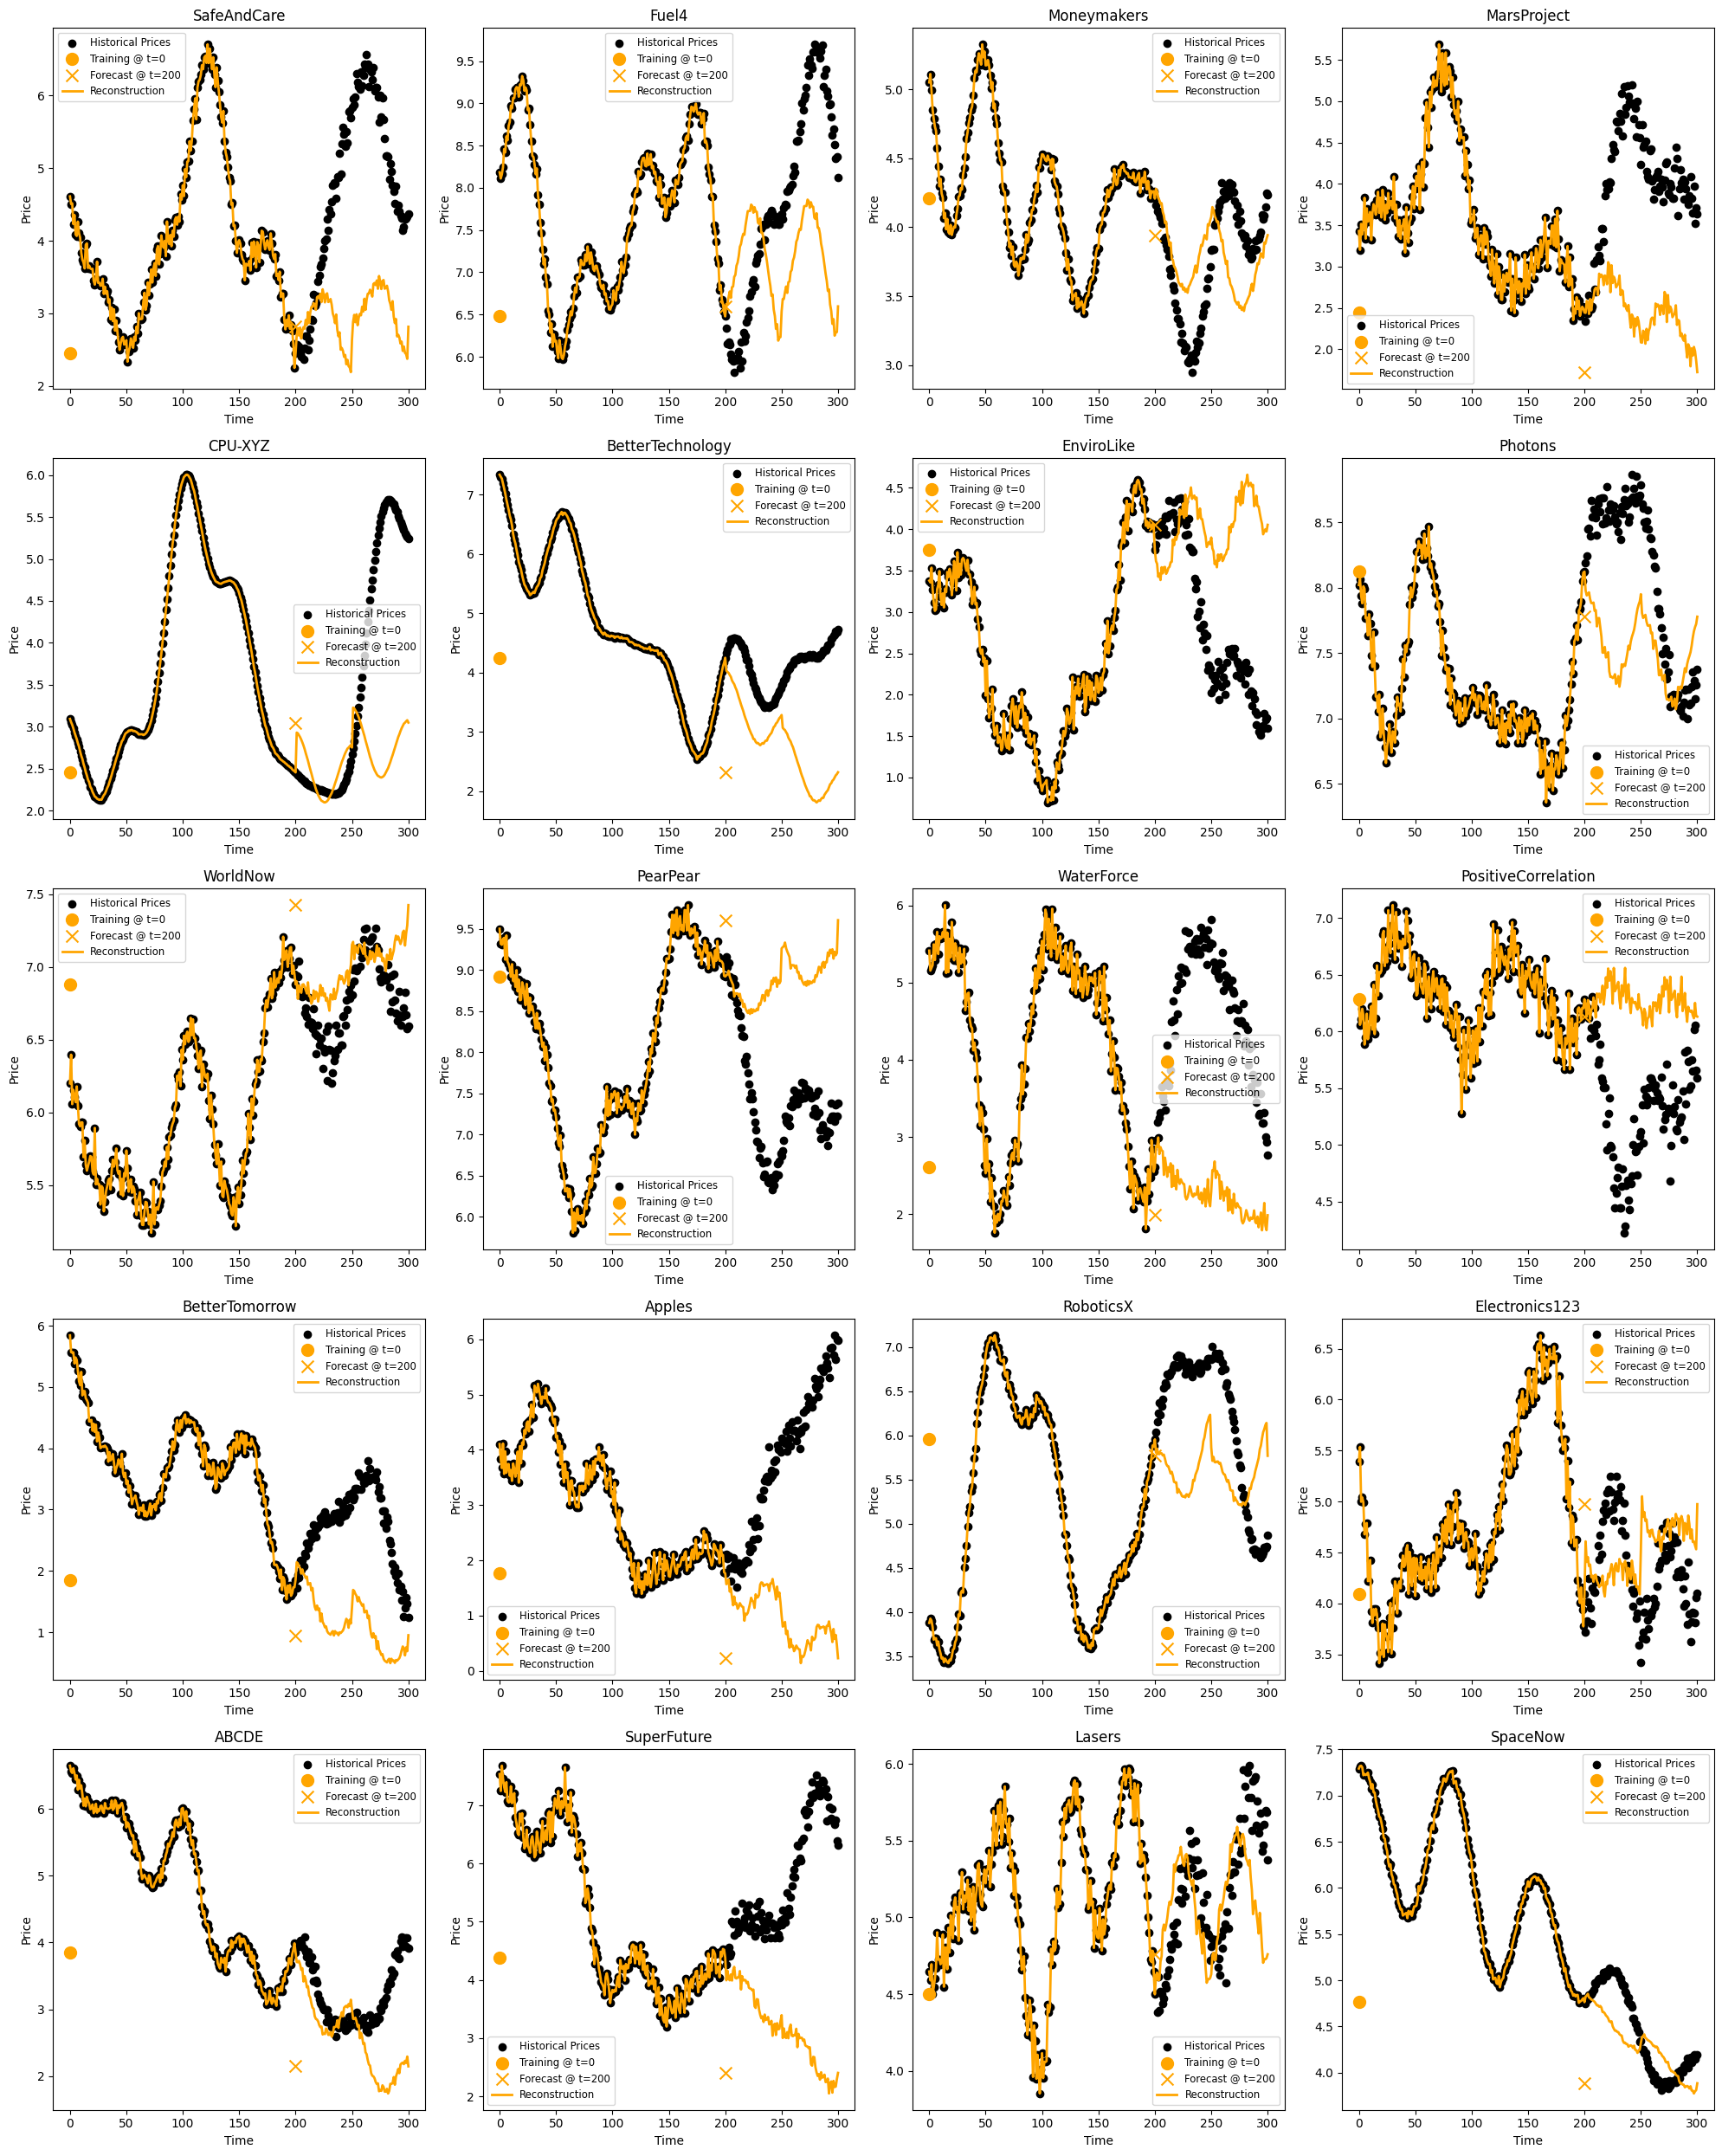

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

def decision_tree_forecast(asset_names, asset_times, asset_prices,
                           training_start=0, training_end=100, forecast_time=200,
                           seasonal_period=None, max_depth=None):
    """
    For each asset, forecast prices using a Decision Tree Regressor with conditional deseasonalization and detrending.
    
    Steps for each asset:
      1. Extract training data from training_start to training_end.
      2. Fit a linear trend (using np.polyfit) to the training data.
      3. Detrend the training data by subtracting the trend.
      4. If seasonal_period is provided and > 1, compute a seasonal component (average residual per seasonal position)
         and remove it (deseasonalize the data).
      5. Fit a Decision Tree Regressor on the deseasonalized residuals.
      6. For forecasting, predict the residuals on new time points, add back the trend (evaluated using the linear model)
         and the seasonal component (if available) to obtain the final forecast.
    """
    dt_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # 1. Select training data
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        # 2. Fit a linear trend for detrending (using a first-degree polynomial)
        coeffs = np.polyfit(t_train, p_train, deg=1)
        trend_train = np.polyval(coeffs, t_train)
        
        # 3. Detrend the training data
        p_detrended = p_train - trend_train
        
        # 4. Conditional deseasonalization if a seasonal period is provided
        if seasonal_period is not None and seasonal_period > 1:
            # Compute the average seasonal effect for each season position
            seasonal_effect = np.zeros(seasonal_period)
            count = np.zeros(seasonal_period)
            for idx, t in enumerate(t_train):
                pos = int((t - training_start) % seasonal_period)
                seasonal_effect[pos] += p_detrended[idx]
                count[pos] += 1
            # Avoid division by zero and compute average
            seasonal_effect = np.where(count > 0, seasonal_effect / count, 0)
            # Build the seasonal component for each training time
            seasonal_train = np.array([seasonal_effect[int((t - training_start) % seasonal_period)]
                                       for t in t_train])
            # Remove seasonal effect from the detrended data
            p_deseasonalized = p_detrended - seasonal_train
        else:
            p_deseasonalized = p_detrended
            seasonal_train = np.zeros_like(p_train)  # no seasonal component
        
        # 5. Fit Decision Tree Regressor on the deseasonalized (residual) training data.
        dt_reg = DecisionTreeRegressor(max_depth=max_depth)
        dt_reg.fit(t_train.reshape(-1, 1), p_deseasonalized)
        
        # In-sample prediction on training data (residual prediction)
        pred_deseasonalized_train = dt_reg.predict(t_train.reshape(-1, 1))
        # Reconstruct training predictions by adding back the trend and seasonal component (if any)
        pred_train_reconstructed = pred_deseasonalized_train + trend_train
        if seasonal_period is not None and seasonal_period > 1:
            pred_train_reconstructed += seasonal_train
        
        # 6. Forecasting for times after training_end
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        # Predict the residuals for forecast times
        pred_deseasonalized_forecast = dt_reg.predict(forecast_times.reshape(-1, 1))
        # Evaluate trend for forecast times
        trend_forecast = np.polyval(coeffs, forecast_times)
        # If seasonal, compute seasonal component for forecast times
        if seasonal_period is not None and seasonal_period > 1:
            seasonal_forecast = np.array([seasonal_effect[int((t - training_start) % seasonal_period)]
                                          for t in forecast_times])
        else:
            seasonal_forecast = np.zeros_like(forecast_times)
        # Reconstruct forecasted predictions
        forecast_pred = pred_deseasonalized_forecast + trend_forecast + seasonal_forecast
        
        # 7. Build full reconstruction of predictions (training + forecast)
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([pred_train_reconstructed, forecast_pred])
        
        # Determine price at training_end (last training prediction) and at forecast_time (last forecast value)
        price_at_training = pred_train_reconstructed[-1]
        price_at_forecast = forecast_pred[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        dt_pred[name] = {
            "model_predictions": (t_train, pred_train_reconstructed),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
        
    return dt_pred

# Example usage:
dt_results = decision_tree_forecast(asset_names, asset_times, asset_prices,
                                    training_start=0, training_end=200, forecast_time=300,
                                    seasonal_period=50, max_depth=50)
plot_asset_forecasts(asset_names, asset_times, asset_prices, dt_results, training_offset=200, color="orange")


/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


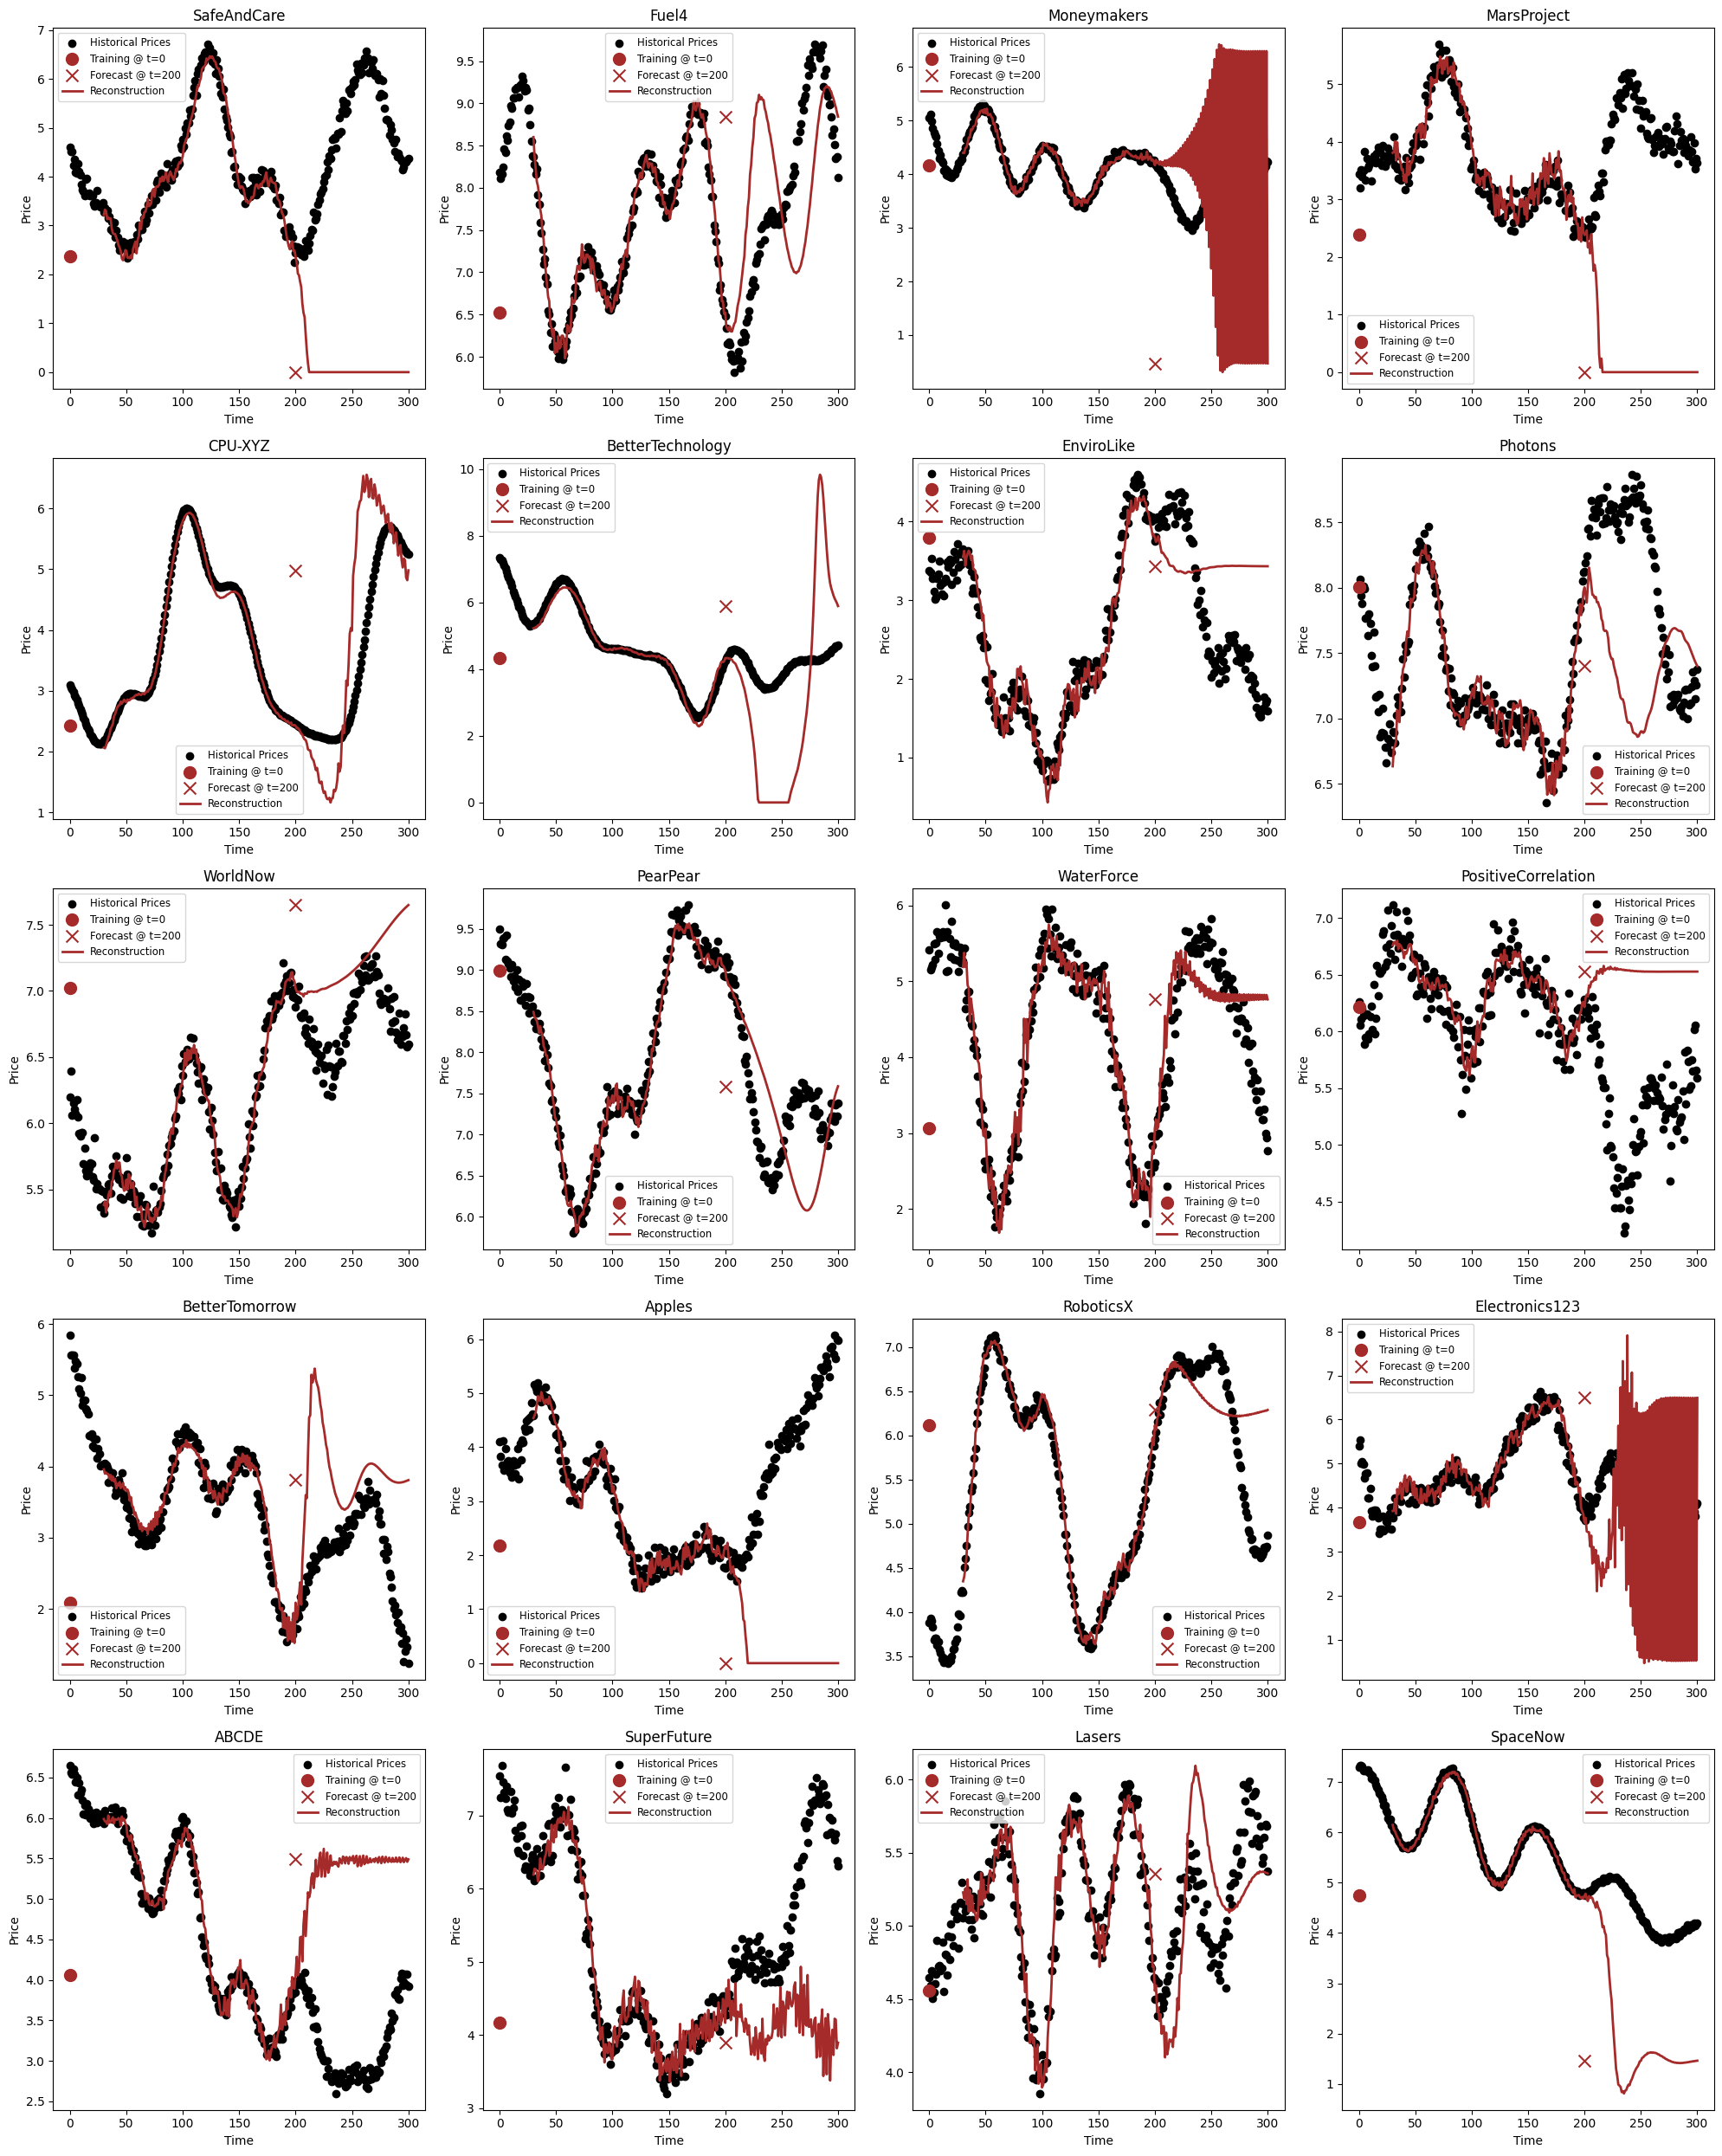

In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def create_dataset(data, look_back):
    """
    Create sliding-window sequences for training.
    
    Args:
      data: 1D numpy array of normalized asset prices.
      look_back: number of time steps to use as input.
      
    Returns:
      X: numpy array of shape (n_samples, look_back)
      y: numpy array of shape (n_samples,)
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

def rnn_forecast(asset_names, asset_times, asset_prices,
                 training_start=0, training_end=100, forecast_time=200,
                 look_back=10, epochs=20, batch_size=64):
    """
    For each asset, this function:
      1. Selects training data in [training_start, training_end].
      2. Computes the min and max of the training data and normalizes it.
      3. Creates sliding-window sequences and trains an RNN model on the normalized data.
      4. Makes in-sample predictions and recursively forecasts until forecast_time (all in normalized space).
      5. Transforms the predictions back to the original scale using the stored min and max.
      6. Clipping: Any negative values in the predictions (both in-sample and forecast) are set to 0.
    """
    rnn_pred = {}
    
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data using the provided time window.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        if len(p_train) <= look_back:
            raise ValueError(f"Not enough training data for asset {name} with look_back = {look_back}.")
        
        # Get the min and max from the training data (original scale).
        train_min = p_train.min()
        train_max = p_train.max()
        
        # Normalize the training data.
        p_train_norm = (p_train - train_min) / (train_max - train_min)
        
        # Create sliding-window sequences on the normalized data.
        X_train, y_train = create_dataset(p_train_norm, look_back)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        
        # Build the RNN model using the specified architecture.
        model = Sequential()
        model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(SimpleRNN(units=50, return_sequences=False))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Train the RNN model on normalized data (verbose=0 to suppress output)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # In-sample predictions on the normalized training data.
        pred_train_norm = model.predict(X_train, verbose=0).flatten()
        # Inverse transform the normalized predictions to the original scale.
        pred_train = pred_train_norm * (train_max - train_min) + train_min
        # Clip any negative predictions to 0.
        pred_train = np.maximum(pred_train, 0)
        # The in-sample predictions correspond to times t_train[look_back:].
        t_train_pred = t_train[look_back:]
        
        # Determine forecast steps (assumes integer time steps).
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Recursive forecasting: use the last look_back normalized values to predict the next value.
        last_sequence = p_train_norm[-look_back:].tolist()
        forecasted_norm = []
        for _ in range(forecast_steps):
            input_seq = np.array(last_sequence[-look_back:]).reshape((1, look_back, 1))
            next_val_norm = model.predict(input_seq, verbose=0)[0, 0]
            forecasted_norm.append(next_val_norm)
            last_sequence.append(next_val_norm)
        
        # Inverse-transform the forecasted normalized predictions.
        forecasted = np.array(forecasted_norm) * (train_max - train_min) + train_min
        # Clip negative forecast values.
        forecasted = np.maximum(forecasted, 0)
        
        # Construct full reconstruction: combine in-sample predictions and forecasted values.
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        full_times = np.concatenate([t_train_pred, forecast_times])
        full_predictions = np.concatenate([pred_train, forecasted])
        full_predictions = np.maximum(full_predictions, 0)
        
        price_at_training = pred_train[-1]
        price_at_forecast = forecasted[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        rnn_pred[name] = {
            "model_predictions": (t_train_pred, pred_train),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    
    return rnn_pred

# (Assuming asset_names, asset_times, asset_prices, and plot_asset_forecasts are defined)
rnn_results = rnn_forecast(asset_names, asset_times, asset_prices,
                           training_start=0, training_end=200, forecast_time=300,
                           look_back=30, epochs=20, batch_size=64)
plot_asset_forecasts(asset_names, asset_times, asset_prices, rnn_results, training_offset=200, color="brown")


Asset: SafeAndCare
Real training price (last value in training data): 4.3727
Method           TrainPred   Forecast   Return (%)
--------------------------------------------------
RNN                 2.3623     0.0000         0.00
DecisionTree        2.4485     2.8153       114.98
Naive               2.4485     2.4485       100.00
ExpSmoothing        2.4227     0.1163         4.80
ARIMA               2.4586     1.6496        67.09
Sparse              3.9144     0.0000         0.00
Linear              4.3844     4.7511       108.36
--------------------------------------------------
Median              2.4485     1.6496        67.09
Mean                2.9199     1.6830        56.46

Asset: Fuel4
Real training price (last value in training data): 8.1181
Method           TrainPred   Forecast   Return (%)
--------------------------------------------------
RNN                 6.5212     8.8424       135.59
DecisionTree        6.4781     6.5962       101.82
Naive               6.4781     6.4

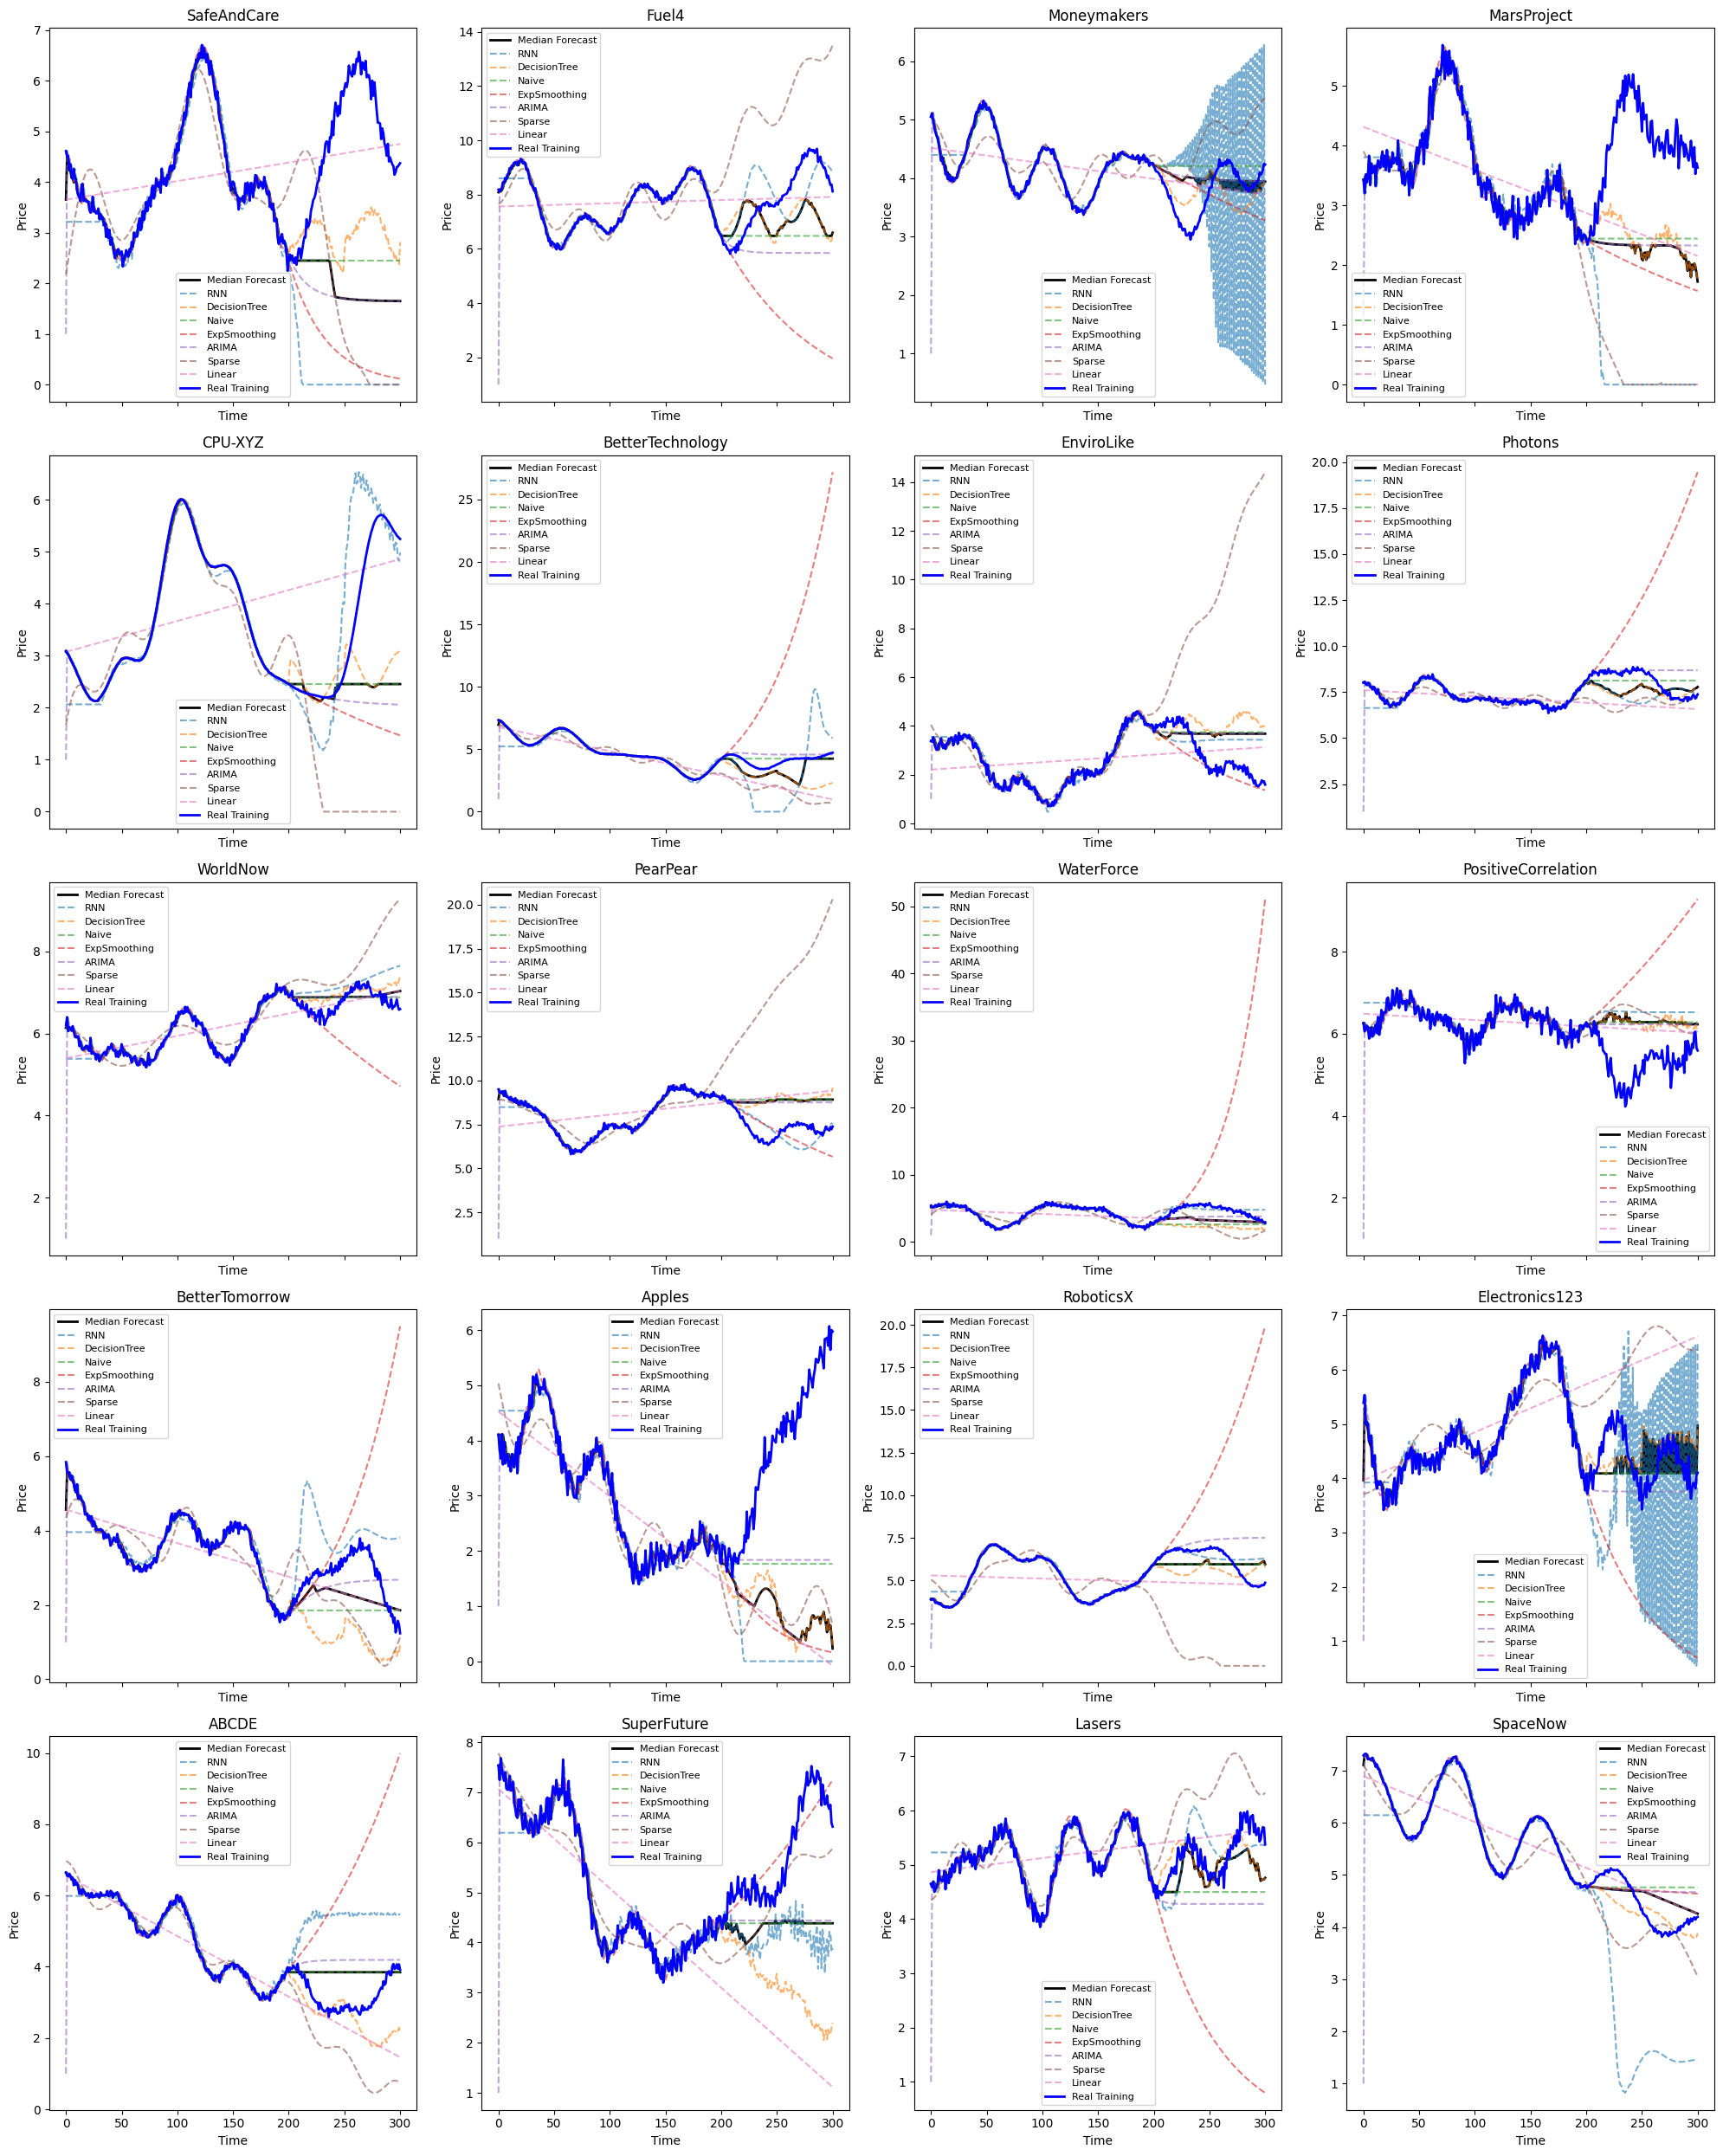

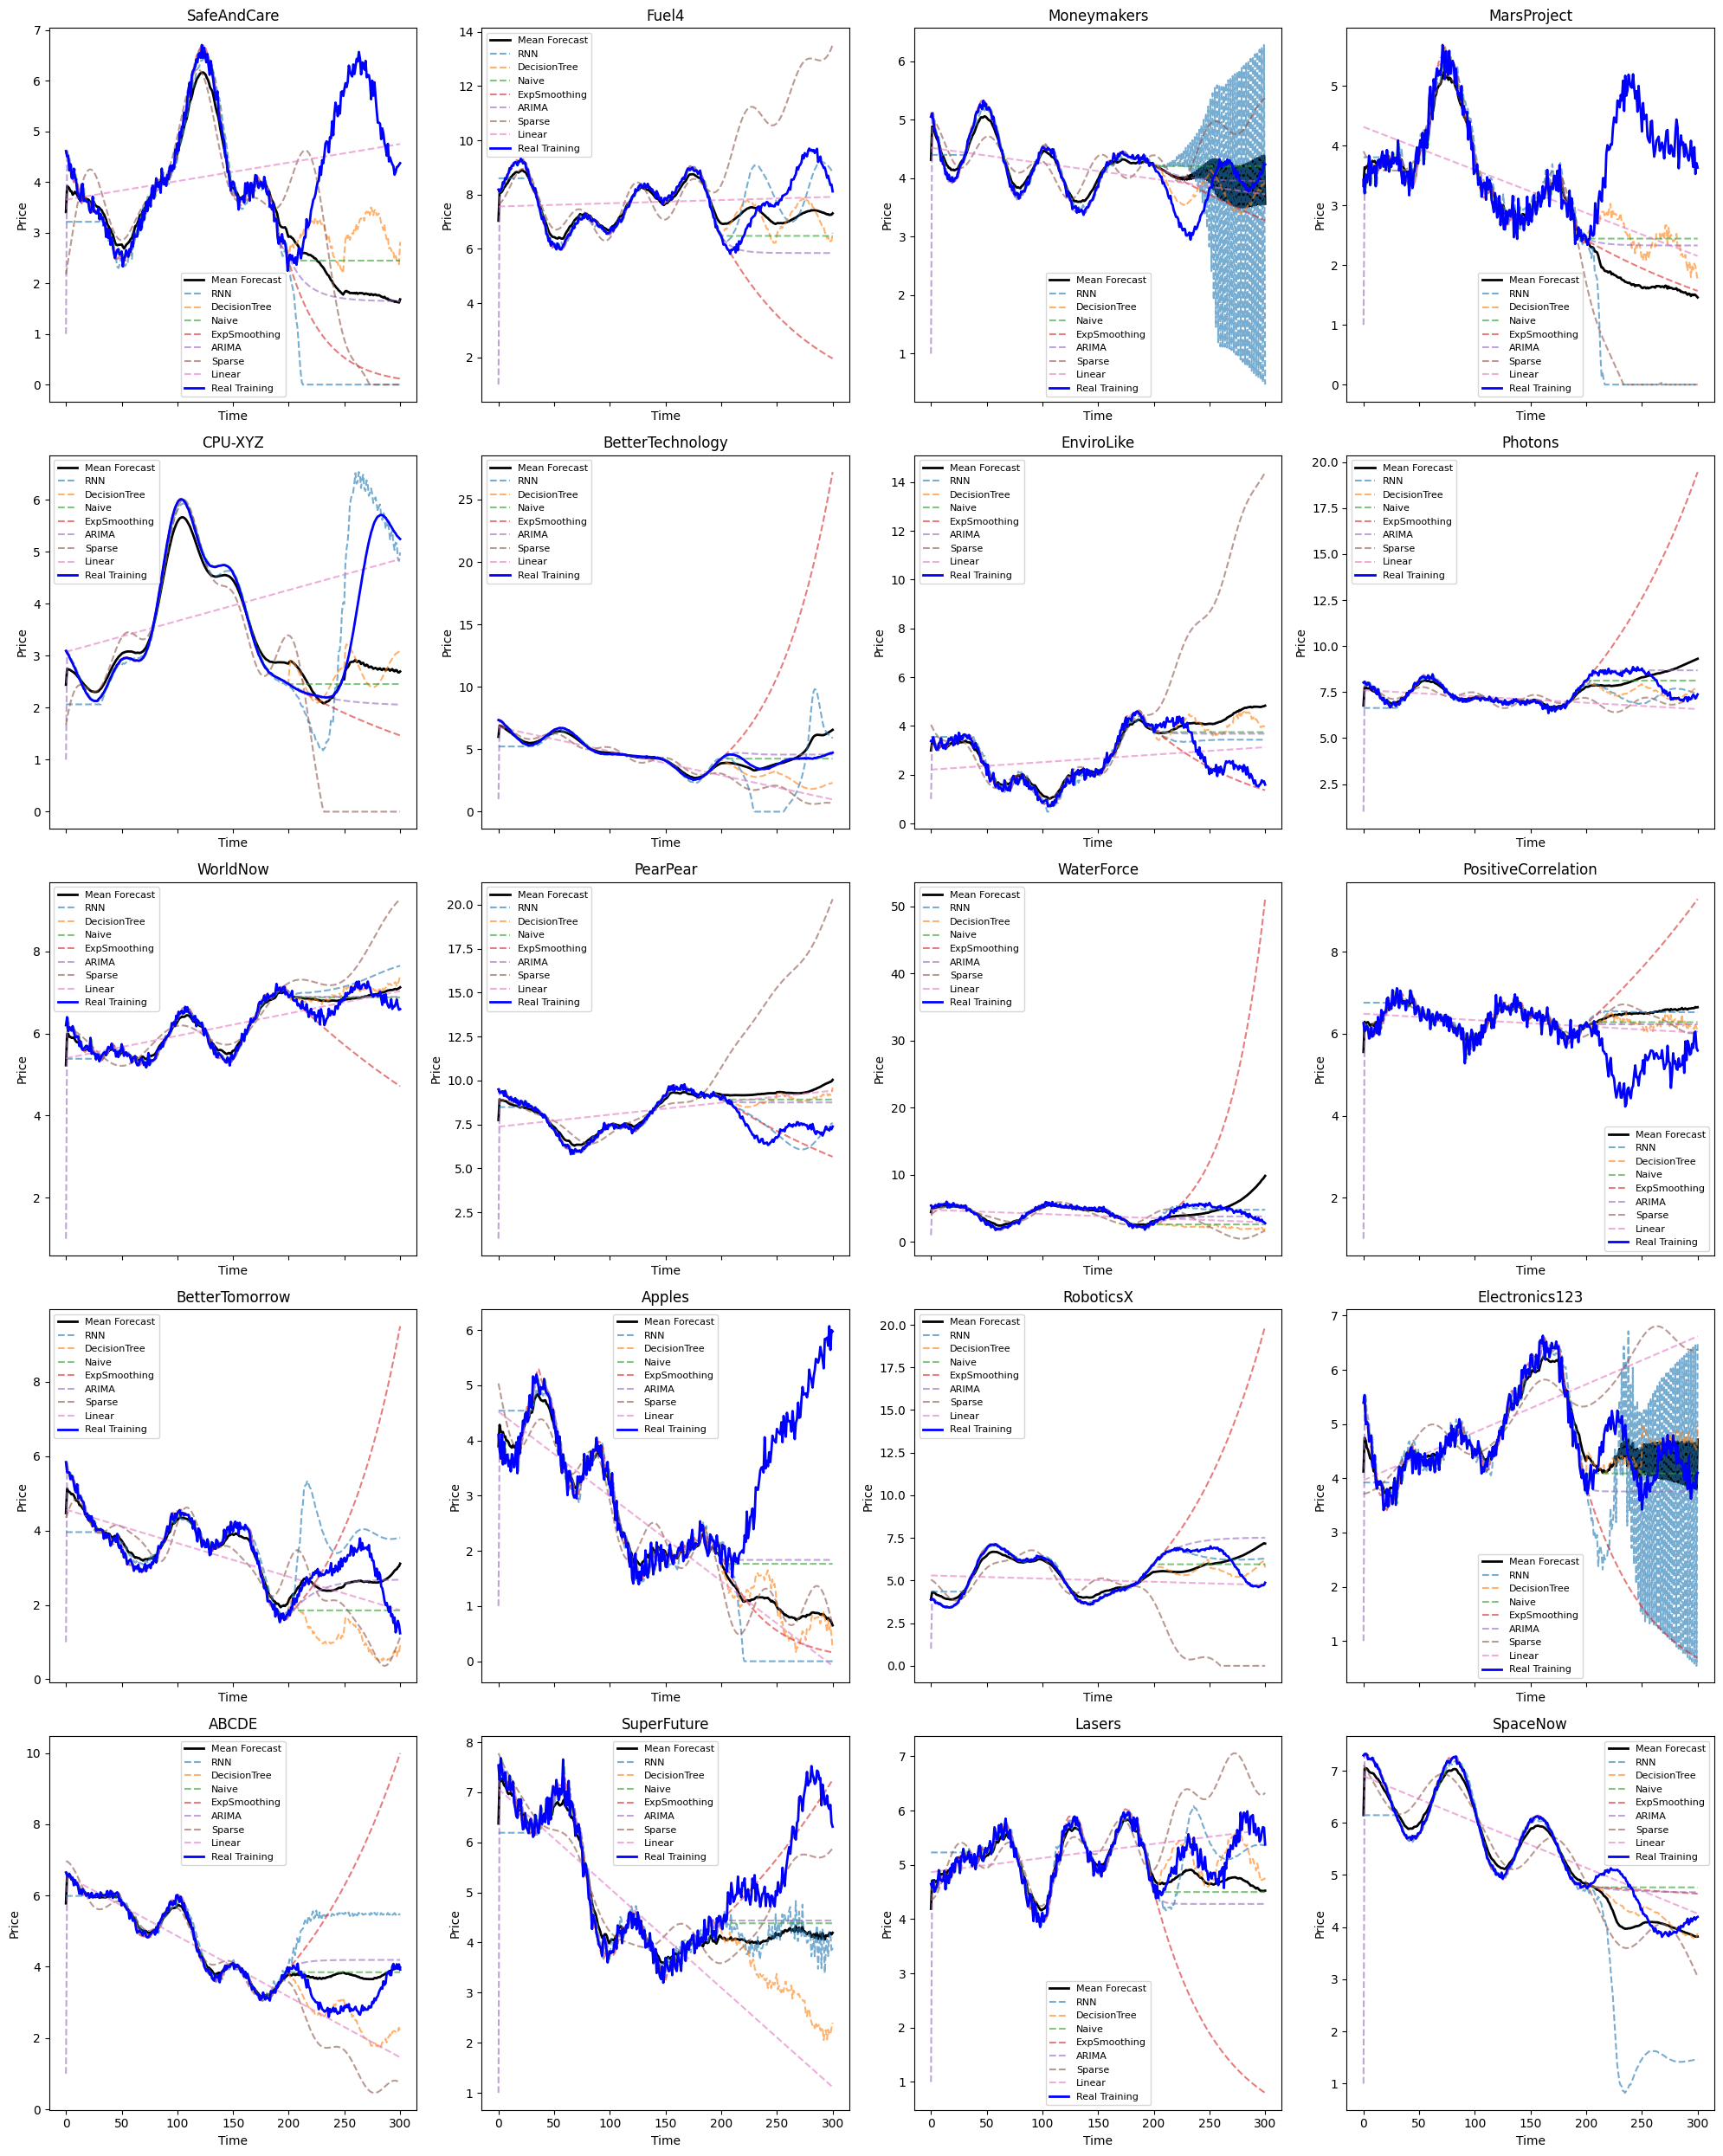

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def aggregate_and_plot_mean_median(asset_names, asset_times, asset_prices,
                                   rnn_results, dt_results, naive_results, exp_results,
                                   arima_results, sparse_results, linear_results,
                                   training_start=0, training_end=100, forecast_time=200):
    """
    For each asset, this function:
      - Prints a table of predicted training price, forecast price, and expected return (in %)
        for each forecasting method.
      - Computes the pointwise median and mean forecasts across methods.
      - Displays two separate 5×4 grids: one for the median forecast and one for the mean forecast.
    
    Expected return is computed as (forecast / training_price)*100%.
    
    Returns a dictionary with two keys: "median" and "mean". Each value is a dictionary where each asset
    is represented with keys:
      - "model_predictions": (training_times, aggregated in-sample predictions) – here we fill the training period with the aggregated training price.
      - "full_reconstruction": (common_times, aggregated full forecast)
      - "price_at_training": aggregated training price (scalar)
      - "price_at_forecast": aggregated forecast price (scalar)
      - "predicted_return": aggregated expected return (scalar)
    """
    # Combine forecast dictionaries.
    methods = {
        'RNN': rnn_results,
        'DecisionTree': dt_results,
        'Naive': naive_results,
        'ExpSmoothing': exp_results,
        'ARIMA': arima_results,
        'Sparse': sparse_results,
        'Linear': linear_results
    }
    
    # Create a common time axis.
    common_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
    
    # Containers for aggregated results.
    median_results = {}
    mean_results = {}
    
    # Loop over assets.
    for idx, asset in enumerate(asset_names):
        print(f"\n{'='*60}\nAsset: {asset}")
        
        # Get asset training data.
        times = np.array(asset_times[idx])
        prices = np.array(asset_prices[idx])
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        real_training_price = prices[mask][-1]
        print(f"Real training price (last value in training data): {real_training_price:.4f}")
        
        # Initialize lists to collect scalar predictions and aligned full forecasts.
        training_preds = []    # from each method: price_at_training
        forecast_preds = []    # from each method: price_at_forecast
        exp_returns = []       # expected return in percentage
        full_predictions_aligned = []  # each element is an array aligned on common_times
        
        # Print table header.
        header = f"{'Method':<15} {'TrainPred':>10} {'Forecast':>10} {'Return (%)':>12}"
        print(header)
        print("-" * len(header))
        
        for method_name, result in methods.items():
            if asset not in result:
                continue
            res = result[asset]
            train_pred = res["price_at_training"]
            forecast_pred = res["price_at_forecast"]
            # Expected return = (forecast / train_pred)*100%
            exp_return = (forecast_pred / train_pred) * 100.0
            print(f"{method_name:<15} {train_pred:10.4f} {forecast_pred:10.4f} {exp_return:12.2f}")
            training_preds.append(train_pred)
            forecast_preds.append(forecast_pred)
            exp_returns.append(exp_return)
            # Interpolate full reconstruction on common_times.
            method_times, method_preds = res["full_reconstruction"]
            aligned = np.interp(common_times, method_times, method_preds)
            full_predictions_aligned.append(aligned)
        
        # Compute aggregated scalar values.
        median_train = np.median(training_preds)
        median_forecast = np.median(forecast_preds)
        median_return = np.median(exp_returns)
        mean_train = np.mean(training_preds)
        mean_forecast = np.mean(forecast_preds)
        mean_return = np.mean(exp_returns)
        print("-" * len(header))
        print(f"{'Median':<15} {median_train:10.4f} {median_forecast:10.4f} {median_return:12.2f}")
        print(f"{'Mean':<15} {mean_train:10.4f} {mean_forecast:10.4f} {mean_return:12.2f}")
        
        # Compute pointwise aggregated forecasts.
        full_predictions_aligned = np.array(full_predictions_aligned)
        median_full = np.median(full_predictions_aligned, axis=0)
        mean_full = np.mean(full_predictions_aligned, axis=0)
        
        # Save aggregated results for this asset.
        # For in-sample predictions, we simply fill the training period with the aggregated training price.
        median_results[asset] = {
            "model_predictions": (t_train, np.full_like(t_train, median_train)),
            "full_reconstruction": (common_times, median_full),
            "price_at_training": median_train,
            "price_at_forecast": median_forecast,
            "predicted_return": median_return
        }
        mean_results[asset] = {
            "model_predictions": (t_train, np.full_like(t_train, mean_train)),
            "full_reconstruction": (common_times, mean_full),
            "price_at_training": mean_train,
            "price_at_forecast": mean_forecast,
            "predicted_return": mean_return
        }
    
    # Plotting: Two separate 5x4 charts.
    n_assets = len(asset_names)
    n_rows, n_cols = 5, 4
    
    # Figure for Median forecasts.
    fig_med, axes_med = plt.subplots(n_rows, n_cols, figsize=(20, 25), sharex=True, sharey=False)
    axes_med = axes_med.flatten()
    for idx, asset in enumerate(asset_names):
        ax = axes_med[idx]
        # Plot aggregated median forecast.
        ax.plot(common_times, median_results[asset]["full_reconstruction"][1], label="Median Forecast", color='black', linewidth=2)
        # Plot each method's forecast.
        for method_name, result in methods.items():
            if asset in result:
                m_times, m_preds = result[asset]["full_reconstruction"]
                aligned = np.interp(common_times, m_times, m_preds)
                ax.plot(common_times, aligned, label=method_name, linestyle="--", alpha=0.6)
        # Plot real training data.
        mask = (np.array(asset_times[asset_names.index(asset)]) >= training_start) & (np.array(asset_times[asset_names.index(asset)]) <= training_end)
        t_train = np.array(asset_times[asset_names.index(asset)])[mask]
        ax.plot(t_train, np.array(asset_prices[asset_names.index(asset)])[mask], label="Real Training", color="blue", linewidth=2)
        ax.set_title(asset)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)
    # Hide any unused subplots.
    for j in range(idx+1, n_rows*n_cols):
        axes_med[j].axis('off')
    fig_med.tight_layout()
    
    # Figure for Mean forecasts.
    fig_mean, axes_mean = plt.subplots(n_rows, n_cols, figsize=(20, 25), sharex=True, sharey=False)
    axes_mean = axes_mean.flatten()
    for idx, asset in enumerate(asset_names):
        ax = axes_mean[idx]
        # Plot aggregated mean forecast.
        ax.plot(common_times, mean_results[asset]["full_reconstruction"][1], label="Mean Forecast", color='black', linewidth=2)
        # Plot each method's forecast.
        for method_name, result in methods.items():
            if asset in result:
                m_times, m_preds = result[asset]["full_reconstruction"]
                aligned = np.interp(common_times, m_times, m_preds)
                ax.plot(common_times, aligned, label=method_name, linestyle="--", alpha=0.6)
        # Plot real training data.
        mask = (np.array(asset_times[asset_names.index(asset)]) >= training_start) & (np.array(asset_times[asset_names.index(asset)]) <= training_end)
        t_train = np.array(asset_times[asset_names.index(asset)])[mask]
        ax.plot(t_train, np.array(asset_prices[asset_names.index(asset)])[mask], label="Real Training", color="blue", linewidth=2)
        ax.set_title(asset)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)
    for j in range(idx+1, n_rows*n_cols):
        axes_mean[j].axis('off')
    fig_mean.tight_layout()
    
    plt.show()
    
    # Return the aggregated results.
    return {"median": median_results, "mean": mean_results}

results = aggregate_and_plot_mean_median(asset_names, asset_times, asset_prices,
                                         rnn_results, dt_results, naive_results, exp_results,
                                         arima_results, sparse_results, linear_results,
                                         training_start=0, training_end=300, forecast_time=300)